# call clone

In [2]:
import gzip, time
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import seaborn as sns
from Bio.Seq import Seq
from collections import Counter
import os
import cassiopeia as cas
from cassiopeia.mixins import logger
from typing import Dict, List, Tuple
from cassiopeia.preprocess import (
    alignment_utilities,
    constants,
    map_utils,
    doublet_utils,
    lineage_utils,
    UMI_utils,
    utilities,
)
import pickle as pic

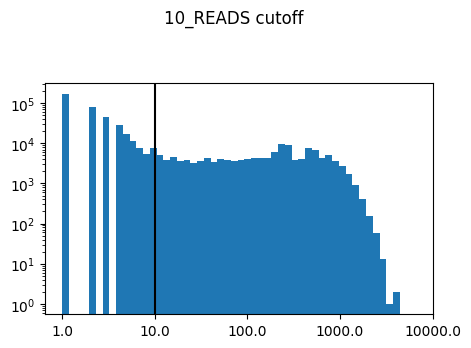

In [3]:
umi_table = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/multiome/cassiopeia_result/staticBC/umi_table_filtered.csv',
                               sep=',',index_col=0,header=0,keep_default_na=False)

plt.figure(figsize=(5,3))
plt.hist(np.log(umi_table['readCount'])/np.log(10), bins=50)
plt.axvline(np.log(10)/np.log(10),c='k')
plt.xticks(range(5),np.logspace(0,4,5))
plt.text(np.log(10)/np.log(10)*1.1,10**7,'10_READS cutoff', fontsize=12)
plt.yscale('log')



In [4]:
umi_table.shape

(507996, 8)

In [5]:
umi_table = umi_table[umi_table['readCount'] >= 10]

In [6]:
umi_table.shape

(137624, 8)

In [7]:
metadata = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/multiome_RNA_metadata.csv',header=0,sep=',',index_col=0)
filtered_cell_barcodes = metadata.index
filtered_cell_barcodes = [ cellBC.replace('-1','') for cellBC in filtered_cell_barcodes ]

umi_table = umi_table[umi_table['cellBC'].isin(filtered_cell_barcodes)]

In [8]:
len(filtered_cell_barcodes)

2568

In [9]:
len(set(umi_table['cellBC']))

2564

In [10]:
umi_table.shape

(79822, 8)

In [11]:
def is_valid(bc):
    return (bc[0:8]=='CACTTTTT' and bc[22:27]=='AAAAG') or (bc[0:28]=='CACTTTTTTCTAGATGAGAAGCGAAAAG')

    
def is_valid_staticBC_prefix(r2_line): # need to 1 mismatch
    staticBC_prefix = 'ATCTGACAGTCACTGTGACG'
    return staticBC_prefix in r2_line

In [12]:
staticBC_prefix = 'ATCTGACAGTCACTGTGACG'
umi_table['umi_remained'] = 'F'
umi_table['intBC'] = 'None'
for i in range(0,len(umi_table.index)):
    seq = umi_table.iloc[i,7]
    if is_valid_staticBC_prefix(seq): 
        seq_sub = seq.split(staticBC_prefix)[1][:31]
        if is_valid(seq_sub):
            umi_table.iloc[i,8] = 'T'
            if seq_sub[0:28]=='CACTTTTTTCTAGATGAGAAGCGAAAAG':
                staticBC = 'TCTAGATGAGAAGCG'
            else:
                staticBC = seq_sub[8:22] 
            umi_table.iloc[i,4] = staticBC

In [13]:
umi_table = umi_table[umi_table['umi_remained']=='T']

In [14]:
umi_table.shape

(69427, 9)

In [15]:
len(set(umi_table['cellBC']))

2564

In [16]:
umi_table

,readName,UMI,cellBC,grpFlag,intBC,qual,readCount,seq,umi_remained
76,AAACAGCCAGGCCATT_GCAAAATTCGAC_1333,GCAAAATTCGAC,AAACAGCCAGGCCATT,0+,CCAAATCGGACGTT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,1333,ACGATCATCTGACAGTCACTGTGACGCACTTTTTCCAAATCGGACG...,T
77,AAACAGCCAGGCCATT_TTGTTTAGGTGA_1132,TTGTTTAGGTGA,AAACAGCCAGGCCATT,0+,CCAAATCGGACGTT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,1132,ACGATCATCTGACAGTCACTGTGACGCACTTTTTCCAAATCGGACG...,T
78,AAACAGCCAGGCCATT_GTTTATAAGTGC_1068,GTTTATAAGTGC,AAACAGCCAGGCCATT,0+,TCATTGGTGGACTC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,1068,ACGATCATCTGACAGTCACTGTGACGCACTTTTTTCATTGGTGGAC...,T
79,AAACAGCCAGGCCATT_GATTCACCCACA_1050,GATTCACCCACA,AAACAGCCAGGCCATT,0+,TCATTGGTGGACTC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,1050,ACGATCATCTGACAGTCACTGTGACGCACTTTTTTCATTGGTGGAC...,T
80,AAACAGCCAGGCCATT_TTTCCCAAATCT_1042,TTTCCCAAATCT,AAACAGCCAGGCCATT,0+,TCATTGGTGGACTC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,1042,ACGATCATCTGACAGTCACTGTGACGCACTTTTTTCATTGGTGGAC...,T
...,...,...,...,...,...,...,...,...,...
507828,TTTGTGTTCCGGTTAG_CGTTGGGTTAAG_67,CGTTGGGTTAAG,TTTGTGTTCCGGTTAG,0+,ATGTCCTTCCCCTA,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,67,ACGATCATCTGACAGTCACTGTGACGCACTTTTTATGTCCTTCCCC...,T
507829,TTTGTGTTCCGGTTAG_TCGTAACACCTA_54,TCGTAACACCTA,TTTGTGTTCCGGTTAG,0,GGCCCAGAGGCAGA,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,54,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGCCCAGAGGCA...,T
507830,TTTGTGTTCCGGTTAG_GATCTTTTTCGT_57,GATCTTTTTCGT,TTTGTGTTCCGGTTAG,0+,ATGTCCTTCCCCTA,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,57,ACGATCATCTGACAGTCACTGTGACGCACTTTTTATGTCCTTCCCC...,T
507831,TTTGTGTTCCGGTTAG_CATTGATTAGAT_24,CATTGATTAGAT,TTTGTGTTCCGGTTAG,0,GGCCCAGAGGCAGA,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,24,ACGATCATCTGACAGTCACTGTGACGCACTTTTTGGCCCAGAGGCA...,T


In [17]:
umi_table['num'] = 1

In [18]:
umi_count = umi_table.groupby(by=['cellBC','intBC'])['num'].sum().reset_index()
umi_count = umi_count[umi_count['num'] > 1]
umi_count

,cellBC,intBC,num
0,AAACAGCCAGGCCATT,CCAAATCGGACGTT,14
1,AAACAGCCAGGCCATT,CGGAACCTGAAAAC,2
2,AAACAGCCAGGCCATT,CGGTGGCGCGAGGG,2
4,AAACAGCCAGGCCATT,GTTAGGGCGACGGA,6
5,AAACAGCCAGGCCATT,GTTTTATCCGCCTG,2
...,...,...,...
14742,TTTGTGTTCATAATCG,GGCCCAGAGGCAGA,11
14743,TTTGTGTTCCGGTTAG,AGAGCGCTCCAAAG,2
14744,TTTGTGTTCCGGTTAG,ATGTCCTTCCCCTA,5
14745,TTTGTGTTCCGGTTAG,CAGCGCGAGACGCC,4


In [19]:
staticBC_whitelist = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/metadata/staticBC_whitelist.txt',header=None)
umi_count = umi_count[umi_count['intBC'].isin(staticBC_whitelist[0].to_list())]

In [20]:
umi_count

,cellBC,intBC,num
0,AAACAGCCAGGCCATT,CCAAATCGGACGTT,14
1,AAACAGCCAGGCCATT,CGGAACCTGAAAAC,2
2,AAACAGCCAGGCCATT,CGGTGGCGCGAGGG,2
4,AAACAGCCAGGCCATT,GTTAGGGCGACGGA,6
5,AAACAGCCAGGCCATT,GTTTTATCCGCCTG,2
...,...,...,...
14742,TTTGTGTTCATAATCG,GGCCCAGAGGCAGA,11
14743,TTTGTGTTCCGGTTAG,AGAGCGCTCCAAAG,2
14744,TTTGTGTTCCGGTTAG,ATGTCCTTCCCCTA,5
14745,TTTGTGTTCCGGTTAG,CAGCGCGAGACGCC,4


In [21]:
len(set(umi_table['cellBC']))

2564

In [21]:
umi_count.to_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/multiome/multiome_staticBC.csv',index=False)

/home/liangzhen/anaconda3/envs/cassiopeia2/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/liangzhen/anaconda3/envs/cassiopeia2/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


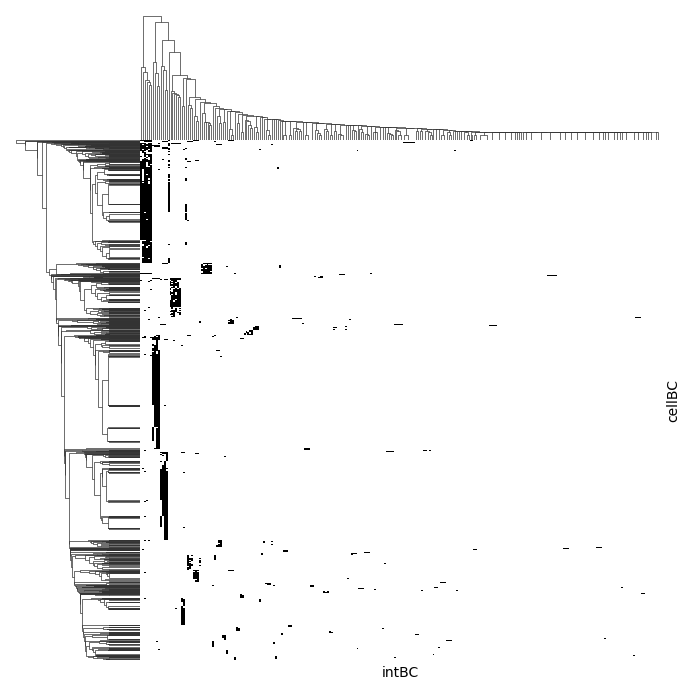

In [22]:
cellBC_staticBC_df = umi_count
cellBC_staticBC_df.index = range(0,len(cellBC_staticBC_df['cellBC']))
#break
cellBC_staticBC_df = cellBC_staticBC_df.pivot(index='cellBC',columns='intBC',values='num')

cellBC_staticBC_df = cellBC_staticBC_df.fillna(0)

cellBC_staticBC_df[cellBC_staticBC_df>0] = 1

# whitelist filter
staticBC_whitelist = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/metadata/staticBC_whitelist.txt',header=None)
cellBC_staticBC_df = cellBC_staticBC_df[list(set(cellBC_staticBC_df.columns).intersection(set(staticBC_whitelist[0].to_list())))]
cellBC_staticBC_df = cellBC_staticBC_df.loc[(cellBC_staticBC_df!=0).any(axis=1)] # remove row all equals 0 
cellBC_staticBC_df = cellBC_staticBC_df[sorted(cellBC_staticBC_df.columns.to_list())]

import seaborn as sns
ax = sns.clustermap(cellBC_staticBC_df, yticklabels=False,xticklabels=False,cmap='binary',figsize=(7, 7),cbar=False)
ax.cax.set_visible(False)


In [23]:
staticBC_whitelist = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/metadata/staticBC_whitelist.txt',header=None)
umi_count = umi_count[umi_count['intBC'].isin(staticBC_whitelist[0].to_list())]

In [24]:
umi_table_tmp = pd.merge(umi_table,umi_count,how='inner',on=['cellBC','intBC'])

In [25]:
piv = pd.pivot_table(
        umi_table_tmp, index="cellBC", columns="intBC", values="UMI", aggfunc="count"
    )

In [26]:
piv = piv.fillna(0)

In [27]:
piv = piv.div(piv.sum(axis=1), axis=0)

In [28]:
pivbin = piv.copy()
pivbin[pivbin > 0] = 1
intBC_sums = pivbin.sum(0)
ordered_intBCs = intBC_sums.sort_values(ascending=False).index.tolist()

piv = piv.loc[pivbin.index[pivbin.sum(1) > 1],ordered_intBCs]

In [34]:
piv

intBC,CAGCGCGAGACGCC,CCTAAGGAACCCGG,ACGGCGGGTCGAAT,ATGTCCTTCCCCTA,CACCTGGACAGGAA,AGAGCGCTCCAAAG,GGCCCAGAGGCAGA,GTTAATGCGACCCG,CCAAATCGGACGTT,AGGCCTCTCCAAAA,...,AGGTGCCCGTAAAG,ACGAGCCGAGCGTA,CGACGGTCGGCTTA,CGCCGGAGGGGCGC,CGCCGGGCGCCCAG,GTTAAACCGCATGT,CTCTGAAACCCAAA,CGCGTTTGCCATAG,GTGAGGAGCGCGGA,ATGGGATGGGAGCT
cellBC,,,,,,,,,,,,,,,,,,,,,
AAACAGCCAGGCCATT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.341463,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATGCACCCTCAC,0.000000,0.000000,0.230769,0.000000,0.307692,0.000000,0.000000,0.230769,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATGCAGGCTACT,0.000000,0.000000,0.458333,0.000000,0.291667,0.000000,0.000000,0.166667,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGGCAAGGACCA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.700000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGGCACAAAGGT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.517241,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCTAGTCTCACC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.307692,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTGAAGTTTGCGG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.437500,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TTTGTGGCAGCACCAT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
min_clust_size = 0 
min_intbc_thresh = 0.1
kinship_thresh = 0.25 
piv_assigned = lineage_utils.assign_lineage_groups(
    piv,
    min_clust_size,
    min_intbc_thresh=min_intbc_thresh,
    kinship_thresh=kinship_thresh,
)

In [30]:
piv_assigned['lineageGrp'].value_counts()

lineageGrp
3     572
1     546
2     406
5     175
4     101
     ... 
45      1
44      1
43      1
42      1
66      1
Name: count, Length: 66, dtype: int64

In [35]:
piv_assigned

intBC,AACTACTGCGAATA,AACTCCGCCGGGAT,AACTCGCCGATTCG,AAGCCCCGAAACCG,AAGCGGGCGGGAAA,AAGGCCCGCTCCCA,AATCCAGTGTGCTG,AATTTACGGCGACG,ACAGACATATTGTG,ACCCATGGCTAAGG,...,TTCTCAGCTCGCAA,TTCTGCCATTCGCT,TTCTGGGATCCCGA,TTGCAAGAAAGAGA,TTGCAGGACAACTA,TTGCAGGGCGGAGG,TTGCCCGCGGCAGC,TTGCGTGAGTACGA,TTTCGCAACCCCCC,lineageGrp
cellBC,,,,,,,,,,,,,,,,,,,,,
AAACATGCACCCTCAC,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
AAACATGCAGGCTACT,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
AAACCGGCAGTGAACG,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
AAACGGATCCTGATGG,0.081081,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
AAATCCGGTTAGGTGC,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AAGGATCCAAGGCCAA,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62
GCTATAGGTTCGGGAT,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63
GCCTATTGTTGGTTGA,0.000000,0.0,0.347826,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64


In [36]:
sum(piv_assigned['lineageGrp'].value_counts()[piv_assigned['lineageGrp'].value_counts() >=15])

2130

In [37]:
2130/2309

0.9224772628843655

In [32]:
master_LGs, master_intBCs = lineage_utils.filter_intbcs_lg_sets(
    piv_assigned, min_intbc_thresh=min_intbc_thresh
)

kinship_scores = lineage_utils.score_lineage_kinships(
    piv_assigned, master_LGs, master_intBCs
)
kinship_scores = kinship_scores[kinship_scores['maxOverlap'] > 0.5] 
piv_assigned = piv_assigned.loc[kinship_scores.index,:]
piv_assigned['lineageGrp'] = kinship_scores['lineageGrp']

piv_assigned['lineageGrp'] = pd.Categorical(piv_assigned['lineageGrp'], categories=piv_assigned['lineageGrp'].value_counts().index, ordered=True)
piv_assigned = piv_assigned.sort_values('lineageGrp')


master_LGs, master_intBCs = lineage_utils.filter_intbcs_lg_sets(
    piv_assigned, min_intbc_thresh=min_intbc_thresh
)

LGs = []
for LG in  piv_assigned['lineageGrp']:
    if LG in LGs:
        pass
    else:
        LGs.append(LG)

intBCs_all = []
master_intBCs_filtered = {} 
for LG in LGs:
    intBCs = master_intBCs[(int(LG),)]
    intBCs = list(set(intBCs).difference(set(intBCs_all)))
    master_intBCs_filtered[(int(LG),)] = intBCs
    intBCs_all = intBCs_all + intBCs
    
intBCs_final = sum(list(master_intBCs_filtered.values()),[]) 

In [33]:
import pickle as pic
with open('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/multiome/master_intBCs_filtered.pickle', 'wb') as f:
    pic.dump(master_intBCs_filtered, f)

In [34]:
master_intBCs_filtered

{(3,): ['ATGTCCTTCCCCTA',
  'GCCTAACAACGAAA',
  'GGCCCAGAGGCAGA',
  'CAGCGCGAGACGCC',
  'CAAGGCACGAAAAC',
  'AGGCCTCTCCAAAA',
  'AGAGCGCTCCAAAG',
  'CCTAAGGAACCCGG'],
 (1,): ['CACCTGGACAGGAA',
  'GGCTTCCGGGTCGG',
  'ACGGCGGGTCGAAT',
  'GTTAATGCGACCCG'],
 (2,): ['GTTAGGGCGACGGA',
  'GTTTTATCCGCCTG',
  'CCAAATCGGACGTT',
  'CGGAACCTGAAAAC'],
 (5,): ['CCCGCTGTCTAGCA',
  'TAGTGGAGACCGCT',
  'GGACCGGACAAATG',
  'AGCGCGCAAGAAAA',
  'CGGAGTCTGGAAAA',
  'CGCGCCAAGACCGA'],
 (4,): ['CGGTGGCGCGAGGG', 'TCCTGAAAGAATGA', 'TCATTGGTGGACTC'],
 (6,): ['CGATTACGGGGGAG',
  'GACGTGGTCGCGGA',
  'GGCGCCAAACTCAG',
  'GTCTGAGAATGGCG',
  'TGAAGGCCGTAAGG'],
 (7,): ['ACTTATTGCGGATG',
  'CTCAAACCTAATAA',
  'GTTGGCCGGCGCAT',
  'CCGTTGCAAACAAG',
  'TCGGCGGAGCACTG',
  'ACGGTATGAGCTTG',
  'CGCGCCGGGTACTT'],
 (8,): ['AGACGCAGAGGGGG',
  'CCACGGGGGGCCGG',
  'GTGCAACGTGTTGG',
  'GCGCGTATGATGCT'],
 (9,): ['AGCTATCGGAAAAA',
  'GCAGCTCCAAAGGC',
  'CCCCCCGAGTCGGG',
  'ATCAGGATCTTCCT',
  'GTAGCGCGGGCGCA'],
 (14,): ['GTCGCCTCAAC

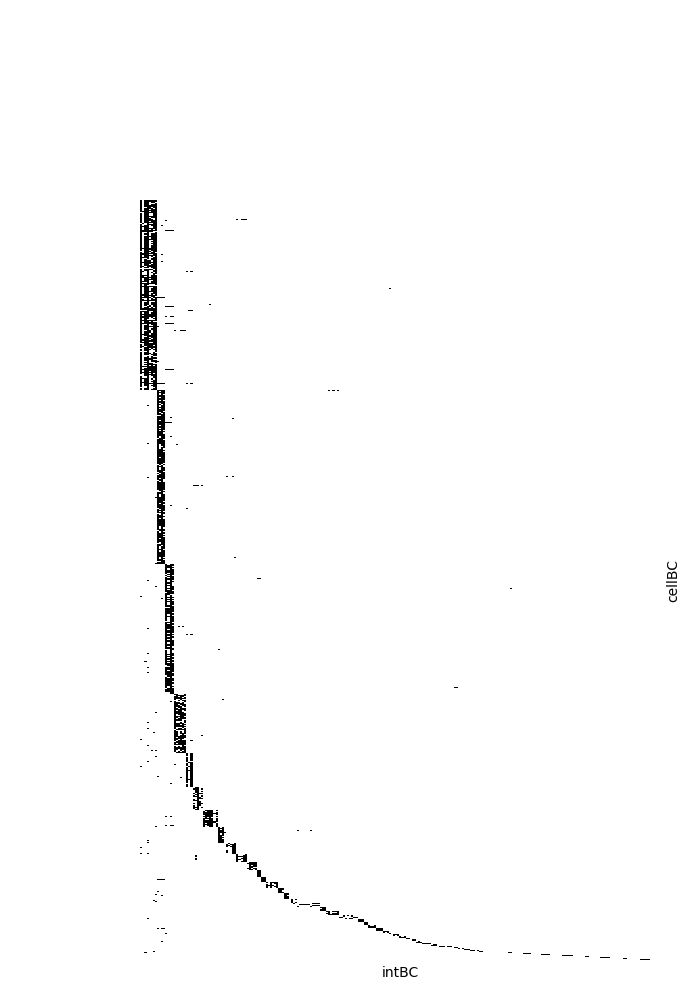

In [35]:
piv_assigned_sub = piv_assigned.iloc[:,0:piv_assigned.shape[1]-1]
piv_assigned_sub[piv_assigned_sub > 0] = 1
piv_assigned_sub = piv_assigned_sub.loc[:,intBCs_final]
ax = sns.clustermap(piv_assigned_sub, cmap='binary',figsize=(7, 10),row_cluster=False,col_cluster=False,yticklabels=False,xticklabels=False)#yticklabels=False,xticklabels=False,,cbar=False,figsize=(7, 7)
ax.cax.set_visible(False)

In [36]:
piv_assigned_sub.shape

(2296, 249)

In [37]:
2431/2827

0.8599221789883269

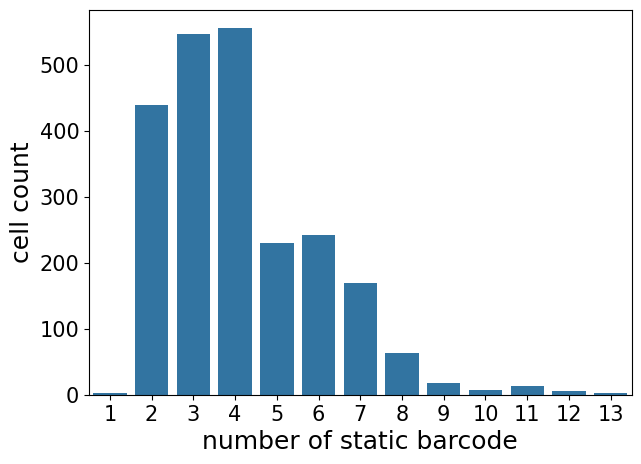

In [38]:
df = piv_assigned_sub.apply(sum,axis=1).sort_values().value_counts().reset_index()
df['index'] = df['index'].astype('int')

plt.rcParams['pdf.fonttype'] = 42
plt.gcf().set_size_inches(7, 5) 
ax = sns.barplot(data=df,x='index',y='count')
ax.set_xlabel('number of static barcode', fontsize=18)
ax.set_ylabel('cell count', fontsize=18)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)

In [39]:
import pickle
with open('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/multiome/piv_assigned.pickle', 'wb') as f:
    pickle.dump(piv_assigned, f)

In [40]:
cell_lineage = piv_assigned['lineageGrp']
cell_lineage.to_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/multiome/cell_lineage.csv')

# call mutation

In [41]:
import cassiopeia as cas
import os
import cassiopeia
import gzip
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats import entropy
import scanpy as sc
from cassiopeia.mixins import logger
from typing import Dict, List, Tuple
from cassiopeia.preprocess import (
    alignment_utilities,
    constants,
    map_utils,
    doublet_utils,
    lineage_utils,
    UMI_utils,
    utilities,
)

import random

In [42]:
gene_names = ['Calr', 'Myl6', 'Calm2', 'Rpl39', 'Cfl1', 'Hsp90b1', 'Calm1', 'Hint1', 'Btf3', 'Lgals1', 'Slc25a3', 'Tpt1', 'Hsp90ab1', 'Fth1']

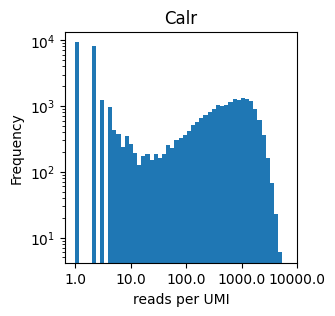

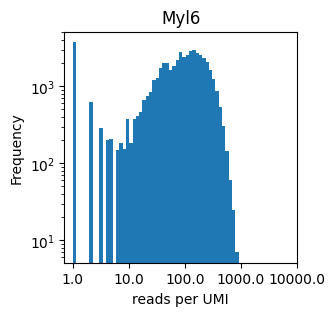

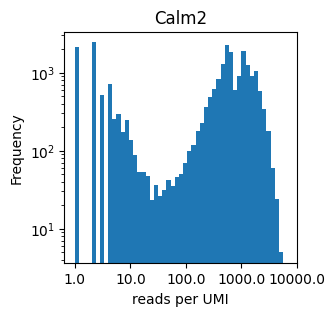

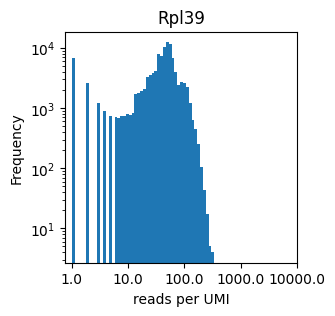

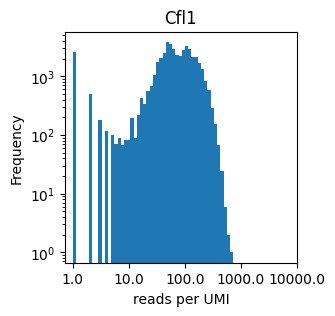

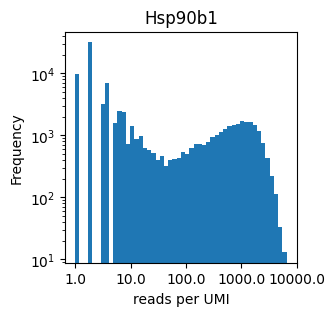

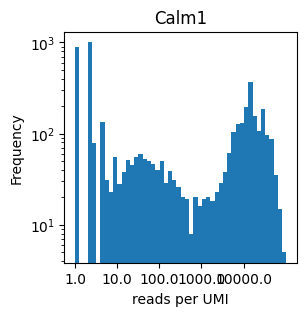

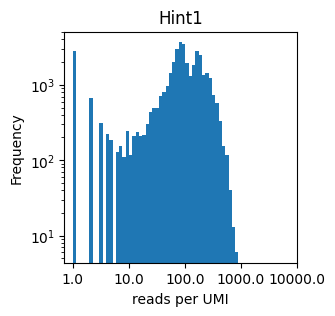

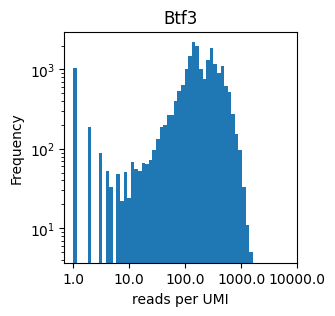

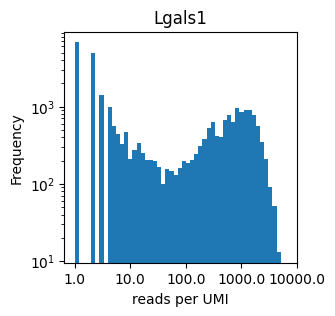

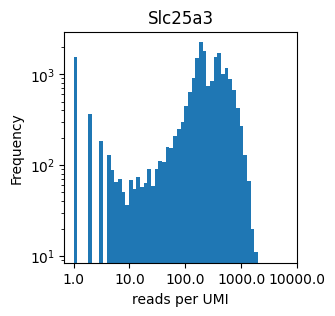

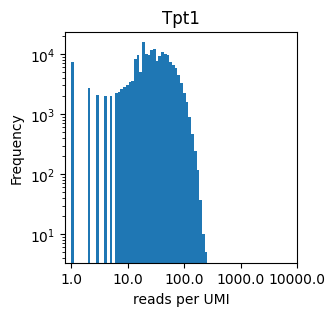

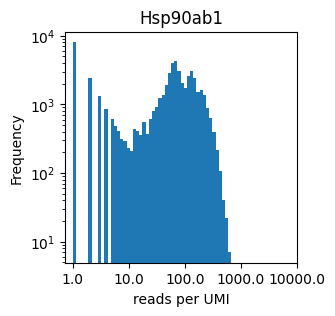

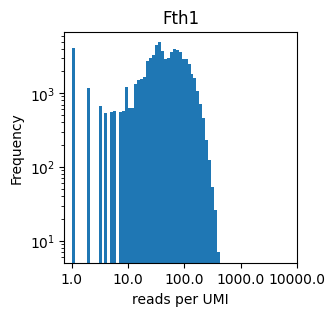

In [43]:
umi_table_all = []

for gene in gene_names:
        umi_table = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/multiome/cassiopeia_result/'+gene+'/'+'umi_table_filtered.csv',
                               sep=',',index_col=0,header=0,keep_default_na=False)
        
        plt.figure(figsize=(3,3))
        plt.hist(np.log(umi_table['readCount'])/np.log(10), bins=50)
        plt.xticks(range(5),np.logspace(0,4,5))
        plt.yscale('log')
        plt.title(gene)
        plt.xlabel('reads per UMI')
        plt.ylabel('Frequency')
        plt.show()
        
        umi_table_all.append(umi_table)
umi_table_df = pd.concat(umi_table_all)

In [44]:
umi_table_df

,readName,AlignmentScore,CIGAR,Mismatch,Mismatch_num,QueryBegin,Ref,ReferenceBegin,Seq,UMI,allele,cellBC,indel_length,indel_num,intBC,length_M,r1,readCount,reads_indel_length,reads_indel_num
0,AAACAGCCAGGACCAA_GTCGGTACGTCG_2140,696,81M5D63M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,0,AATCCGGAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGA...,GTCGGTACGTCG,82:5D,AAACAGCCAGGACCAA,5,1,Calr,144,82:5D,2140,5,1
1,AAACAGCCAGGACCAA_GTCTGTACGTCG_1,720,144M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,0,AATCCGGAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGA...,GTCTGTACGTCG,None,AAACAGCCAGGACCAA,0,0,Calr,144,None,1,0,0
2,AAACAGCCAGGCCATT_TATCAGTTGCTC_1,315,35M91D50M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,0,AATCCGGAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGAGTGT...,TATCAGTTGCTC,36:91D,AAACAGCCAGGCCATT,91,1,Calr,85,36:91D,1,91,1
3,AAACAGCCAGGCCATT_TGTGTCCGTCCA_1,105,20M11I21M1D10M4I32M2D18M,"[[10, 'G>T'], [20, 'C>G'], [24, 'C>A'], [26, '...",34,5,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,0,AATCCGAAGGGGGTTGTGTTTTCCGCGAACCCAGCATCCACGGGTT...,TGTGTCCGTCCA,53:4I85:2D,AAACAGCCAGGCCATT,6,2,Calr,101,53:4I85:2D,1,18,4
4,AAACAGCCAGGCCATT_TTCACCGTAATG_4,674,63M1I17M2D63M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,0,AATCCGGAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGA...,TTCACCGTAATG,64:1I81:2D,AAACAGCCAGGCCATT,3,2,Calr,143,64:1I81:2D,4,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74438,TTTGTGTTCCGGTTAG_CGGACTGTTGAC_246,695,90M1I53M,[],0,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,0,ACTTGAGACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCAC...,CGGACTGTTGAC,91:1I,TTTGTGTTCCGGTTAG,1,1,Fth1,143,91:1I,246,1,1
74439,TTTGTGTTCCGGTTAG_TTGTTAAGGTGC_174,720,144M,[],0,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,0,ACTTGAGACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCAC...,TTGTTAAGGTGC,None,TTTGTGTTCCGGTTAG,0,0,Fth1,144,None,174,0,0
74440,TTTGTGTTCCGGTTAG_TTAAGTCGGATA_61,720,144M,[],0,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,0,ACTTGAGACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCAC...,TTAAGTCGGATA,None,TTTGTGTTCCGGTTAG,0,0,Fth1,144,None,61,0,0
74441,TTTGTGTTCCGGTTAG_AGCAATTCGAAG_58,720,144M,[],0,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,0,ACTTGAGACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCAC...,AGCAATTCGAAG,None,TTTGTGTTCCGGTTAG,0,0,Fth1,144,None,58,0,0


In [45]:
metadata = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/multiome_RNA_metadata.csv',header=0,sep=',',index_col=0)

In [46]:
metadata

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.8,seurat_clusters,RNA_snn_res.0.3,RNA_snn_res.0.4,RNA_snn_res.0.6,predicted.id,prediction.score.2,prediction.score.1,prediction.score.3,prediction.score.4,prediction.score.5,prediction.score.max,umap_1,umap_2
AAACAGCCAGGCCATT-1,SeuratProject,59544,7436,13.786444,4,1,1,0,4,2,1.000000,0.000000,0.000000,0.0,0.000000,1.000000,-5.939390,0.619506
AAACATGCACCCTCAC-1,SeuratProject,11604,3725,10.617029,3,0,0,3,2,3,0.000000,0.236366,0.763634,0.0,0.000000,0.763634,3.650231,-0.803575
AAACATGCAGGCTACT-1,SeuratProject,17107,4309,17.793886,3,0,0,3,2,3,0.004506,0.130255,0.584066,0.0,0.281173,0.584066,1.319984,-0.223603
AAACCGCGTCTTGCTG-1,SeuratProject,17680,4029,19.049774,1,0,0,2,1,3,0.000000,0.010647,0.989353,0.0,0.000000,0.989353,3.240033,-0.833046
AAACCGCGTGGTTCTT-1,SeuratProject,9952,2878,18.488746,2,1,1,0,3,2,1.000000,0.000000,0.000000,0.0,0.000000,1.000000,-3.179854,2.550274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCTAGTCTCACC-1,SeuratProject,21752,4947,11.511585,2,1,1,0,3,2,1.000000,0.000000,0.000000,0.0,0.000000,1.000000,-3.198943,1.809564
TTTGTGAAGTTTGCGG-1,SeuratProject,13142,3660,8.088571,0,0,0,2,1,3,0.000000,0.000000,1.000000,0.0,0.000000,1.000000,1.524957,0.414417
TTTGTGGCAGCACCAT-1,SeuratProject,9245,2845,14.753921,1,2,2,1,0,3,0.000000,0.066865,0.933135,0.0,0.000000,0.933135,1.001207,-1.298838
TTTGTGTTCATAATCG-1,SeuratProject,11275,3176,12.292683,0,0,0,2,1,3,0.000000,0.000000,1.000000,0.0,0.000000,1.000000,3.662393,1.413214


In [47]:
filtered_cell_barcodes = metadata.index
filtered_cell_barcodes = [ cellBC.replace('-1','') for cellBC in filtered_cell_barcodes ]

umi_table_df_filtered = umi_table_df[umi_table_df['cellBC'].isin(filtered_cell_barcodes)]

In [48]:
umi_table_df_filtered

,readName,AlignmentScore,CIGAR,Mismatch,Mismatch_num,QueryBegin,Ref,ReferenceBegin,Seq,UMI,allele,cellBC,indel_length,indel_num,intBC,length_M,r1,readCount,reads_indel_length,reads_indel_num
2,AAACAGCCAGGCCATT_TATCAGTTGCTC_1,315,35M91D50M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,0,AATCCGGAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGAGTGT...,TATCAGTTGCTC,36:91D,AAACAGCCAGGCCATT,91,1,Calr,85,36:91D,1,91,1
3,AAACAGCCAGGCCATT_TGTGTCCGTCCA_1,105,20M11I21M1D10M4I32M2D18M,"[[10, 'G>T'], [20, 'C>G'], [24, 'C>A'], [26, '...",34,5,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,0,AATCCGAAGGGGGTTGTGTTTTCCGCGAACCCAGCATCCACGGGTT...,TGTGTCCGTCCA,53:4I85:2D,AAACAGCCAGGCCATT,6,2,Calr,101,53:4I85:2D,1,18,4
4,AAACAGCCAGGCCATT_TTCACCGTAATG_4,674,63M1I17M2D63M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,0,AATCCGGAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGA...,TTCACCGTAATG,64:1I81:2D,AAACAGCCAGGCCATT,3,2,Calr,143,64:1I81:2D,4,3,2
5,AAACAGCCAGGCCATT_GGTTTTTCCCCC_1,223,68M2I19M4D46M1D9M,"[[18, 'C>T'], [28, 'G>C'], [30, 'A>C'], [32, '...",47,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,0,AATCCGGAAGGGGGTGGTGTTTTTCCTCCCCCCCCCCCTCGGAAAC...,GGTTTTTCCCCC,69:2I88:4D,AAACAGCCAGGCCATT,6,2,Calr,142,69:2I88:4D,1,7,3
6,AAACAGCCAGGCCATT_ACGCAGACAAGT_2,687,73M14D71M,[],0,6,GAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGAATGGGG...,0,AATCCGGAAGGGGGTGGTGTTTTCCCTCCCCCCGCACTGAGGAAGA...,ACGCAGACAAGT,74:14D,AAACAGCCAGGCCATT,14,1,Calr,144,74:14D,2,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74438,TTTGTGTTCCGGTTAG_CGGACTGTTGAC_246,695,90M1I53M,[],0,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,0,ACTTGAGACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCAC...,CGGACTGTTGAC,91:1I,TTTGTGTTCCGGTTAG,1,1,Fth1,143,91:1I,246,1,1
74439,TTTGTGTTCCGGTTAG_TTGTTAAGGTGC_174,720,144M,[],0,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,0,ACTTGAGACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCAC...,TTGTTAAGGTGC,None,TTTGTGTTCCGGTTAG,0,0,Fth1,144,None,174,0,0
74440,TTTGTGTTCCGGTTAG_TTAAGTCGGATA_61,720,144M,[],0,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,0,ACTTGAGACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCAC...,TTAAGTCGGATA,None,TTTGTGTTCCGGTTAG,0,0,Fth1,144,None,61,0,0
74441,TTTGTGTTCCGGTTAG_AGCAATTCGAAG_58,720,144M,[],0,6,GACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCACGTGACT...,0,ACTTGAGACACGGTGATGAGAGCTAAGCTGACTTCCCCAAAGCCAC...,AGCAATTCGAAG,None,TTTGTGTTCCGGTTAG,0,0,Fth1,144,None,58,0,0


In [49]:
len(set(umi_table_df_filtered['cellBC']))

2568

In [50]:
len(set(umi_table_df_filtered['intBC']))

14

In [51]:
umi_table = umi_table_df_filtered.sort_values(by='readCount',ascending=False).groupby(['cellBC','UMI']).head(1)
umi_table = umi_table[umi_table['indel_length'] < 50]
umi_table = umi_table[umi_table['length_M'] > 90]
umi_table = umi_table[umi_table['Mismatch_num'] < 15 ]
umi_table = umi_table[umi_table['readCount'] >= 3 ]

In [52]:
gene_names=['Calr', 'Myl6', 'Calm2', 'Rpl39', 'Cfl1', 'Acta1', 'Hsp90b1', 'Calm1', 
            'Hint1', 'Btf3', 'Lgals1', 'Slc25a3', 'Tpt1', 'Hsp90ab1', 'Fth1']
cut_sites = [80,91,93,87,63,89,89,84,86,94,48,87,89,85,89]
wc = [-17,-3,-3,-17,-3,-17,-3,-17,-3,-17,-17,-17,-17,-3,-17]

intBC_cutSite = pd.concat([pd.DataFrame(data=gene_names,columns=['intBC']),pd.DataFrame(data=cut_sites,columns=['cut_site']),
                          pd.DataFrame(data=wc,columns=['wc'])],axis=1)

In [53]:
umi_table = pd.merge(intBC_cutSite,umi_table,how='inner',on=['intBC'])

In [54]:
## constrain cut site in 30bp the left and right of the cutsite location

def filter_based_on_region(edit):
    cut_site = edit[0]
    mark = np.zeros(200)
    r1 = edit[1]
    #print(edit)
    if 'None' in r1:
        return 'passed'
    indels = re.findall(r'(\d+)([MIDNSHP=X])', r1)
    positions = re.findall(r'(\d+)(:)', r1)
    for indel, position in zip(indels,positions):
        #print(position)
        pos = int(position[0])
        if abs(pos-cut_site)<=12: 
            count = int(indel[0])
            mark[pos:pos+count] = 1
        else:
            return 'failed'

    min_pos = np.where(mark==1)[0][0]
    max_pos = np.where(mark==1)[0][-1]
    cut_min = cut_site - 30
    cut_max = cut_site + 30

    if cut_min > min_pos or cut_max < max_pos:
        return 'failed'
    else:
        return 'passed'
    
#def within_three_bases_upstream(edit,cutsite,wc):

In [55]:
umi_table['r1_isvalid'] = umi_table[['cut_site','r1']].apply(filter_based_on_region,axis=1)
umi_table = umi_table[umi_table['r1_isvalid']=='passed']

In [56]:
allele_table = (
    umi_table.groupby(["cellBC", "intBC", "r1",'allele'])
    .agg({"readCount": "sum", "UMI": "count"})
    .reset_index()
    .sort_values(["UMI", "readCount"], ascending=False)
)


allele_table['UMI_ratio'] = allele_table['UMI'] / allele_table.groupby(["cellBC", "intBC"])['UMI'].transform('sum')
allele_table = allele_table[allele_table['UMI'] >= 2]

In [57]:
allele_table

,cellBC,intBC,r1,allele,readCount,UMI,UMI_ratio
64947,TTATGCGCATCGCTCC,Tpt1,None,None,11551,325,0.984848
44308,GGTACCGGTCACGGAT,Tpt1,None,None,10360,271,0.985455
39962,GCTAAGCGTCAAACTG,Tpt1,None,None,8979,245,0.976096
65572,TTGCAACAGGCAACAA,Tpt1,None,None,7847,224,0.957265
487,AAAGGACGTGACATGC,Tpt1,None,None,8186,214,0.781022
...,...,...,...,...,...,...,...
43828,GGGTATTTCCCTGATC,Hsp90b1,90:1D,90:1D,6,2,0.034483
44707,GGTCCTGCAGGACCTT,Lgals1,None,None,6,2,0.250000
44932,GGTGAGGTCCCTCATA,Rpl39,80:1I92:2I95:1D,80:1I92:2I95:1D,6,2,0.105263
45372,GGTTAGCGTGATGAAA,Hsp90b1,92:1I,92:1I,6,2,0.068966


In [58]:
len(set(allele_table['cellBC']))

2568

In [59]:
cell_lineage = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/multiome/cell_lineage.csv',header=0)
allele_table = pd.merge(allele_table,cell_lineage,how='inner',on=['cellBC'])

In [60]:
allele_table

,cellBC,intBC,r1,allele,readCount,UMI,UMI_ratio,lineageGrp
0,TTATGCGCATCGCTCC,Tpt1,None,None,11551,325,0.984848,3
1,TTATGCGCATCGCTCC,Myl6,None,None,7716,53,0.679487,3
2,TTATGCGCATCGCTCC,Cfl1,None,None,3666,40,0.689655,3
3,TTATGCGCATCGCTCC,Rpl39,85:9D,85:9D,1487,30,0.405405,3
4,TTATGCGCATCGCTCC,Rpl39,88:2D,88:2D,1374,30,0.405405,3
...,...,...,...,...,...,...,...,...
40429,ATCATGTCATGCATAT,Fth1,None,None,134,4,0.571429,3
40430,ATCATGTCATGCATAT,Rpl39,None,None,152,3,0.750000,3
40431,ATCATGTCATGCATAT,Tpt1,82:11D,82:11D,143,2,0.222222,3
40432,AGAGGAACAAGCTTAT,Tpt1,None,None,259,6,0.857143,1


In [61]:
allele_table.to_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/trees/multiome_allele_table.csv')

In [62]:
allele_table['num'] = 1
stat_copy = allele_table.groupby(['cellBC','intBC'])['num'].sum().reset_index()

In [63]:
stat_copy

,cellBC,intBC,num
0,AAACAGCCAGGCCATT,Btf3,1
1,AAACAGCCAGGCCATT,Calm1,1
2,AAACAGCCAGGCCATT,Calm2,3
3,AAACAGCCAGGCCATT,Calr,2
4,AAACAGCCAGGCCATT,Cfl1,2
...,...,...,...
26247,TTTGTGTTCCGGTTAG,Fth1,2
26248,TTTGTGTTCCGGTTAG,Hsp90ab1,1
26249,TTTGTGTTCCGGTTAG,Myl6,1
26250,TTTGTGTTCCGGTTAG,Rpl39,1


In [64]:
stat_copy['num'].value_counts()

num
1    17280
2     5533
3     2160
4      890
5      308
6       61
7       18
8        2
Name: count, dtype: int64

/tmp/ipykernel_216558/1184422426.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_edit_info['num'] = 1


<Figure size 600x600 with 0 Axes>

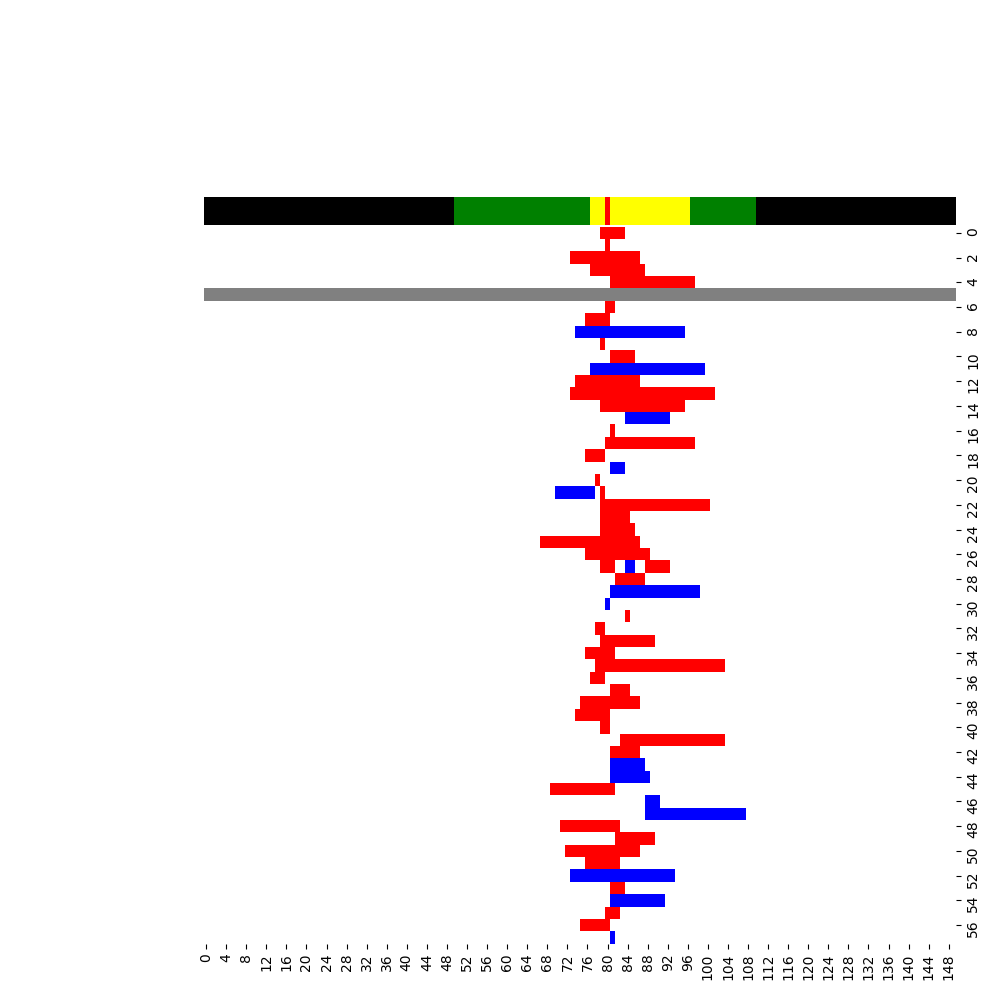

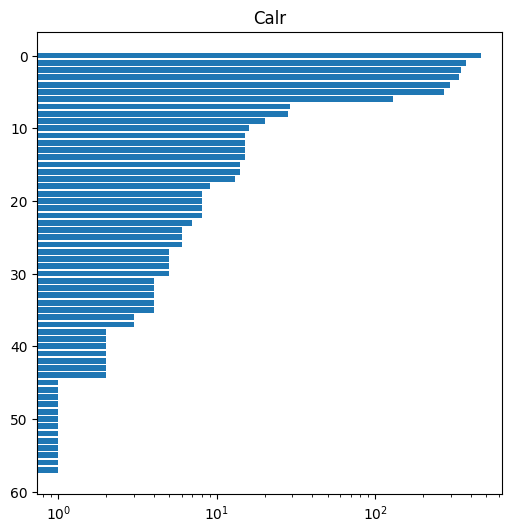

/tmp/ipykernel_216558/1184422426.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_edit_info['num'] = 1


<Figure size 600x600 with 0 Axes>

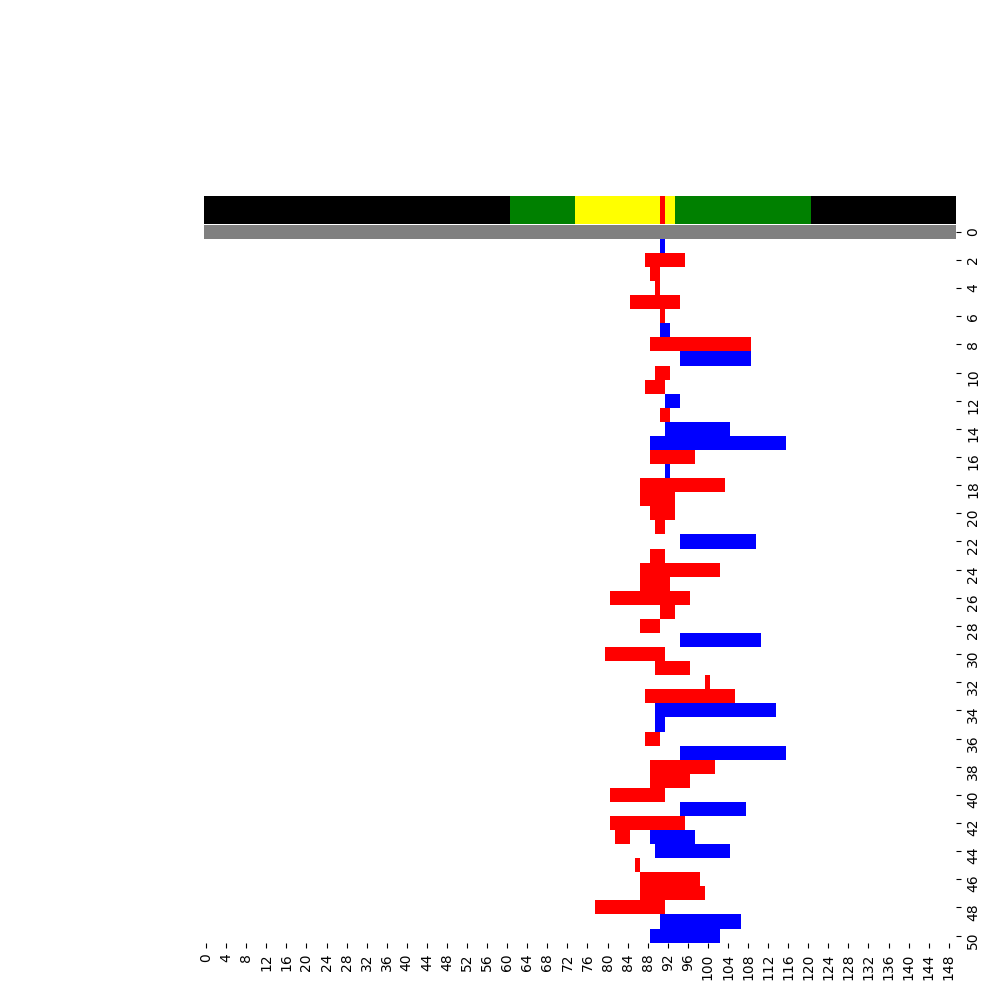

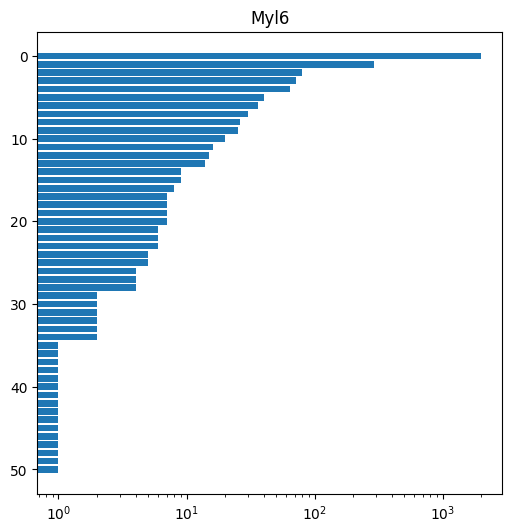

/tmp/ipykernel_216558/1184422426.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_edit_info['num'] = 1


<Figure size 600x600 with 0 Axes>

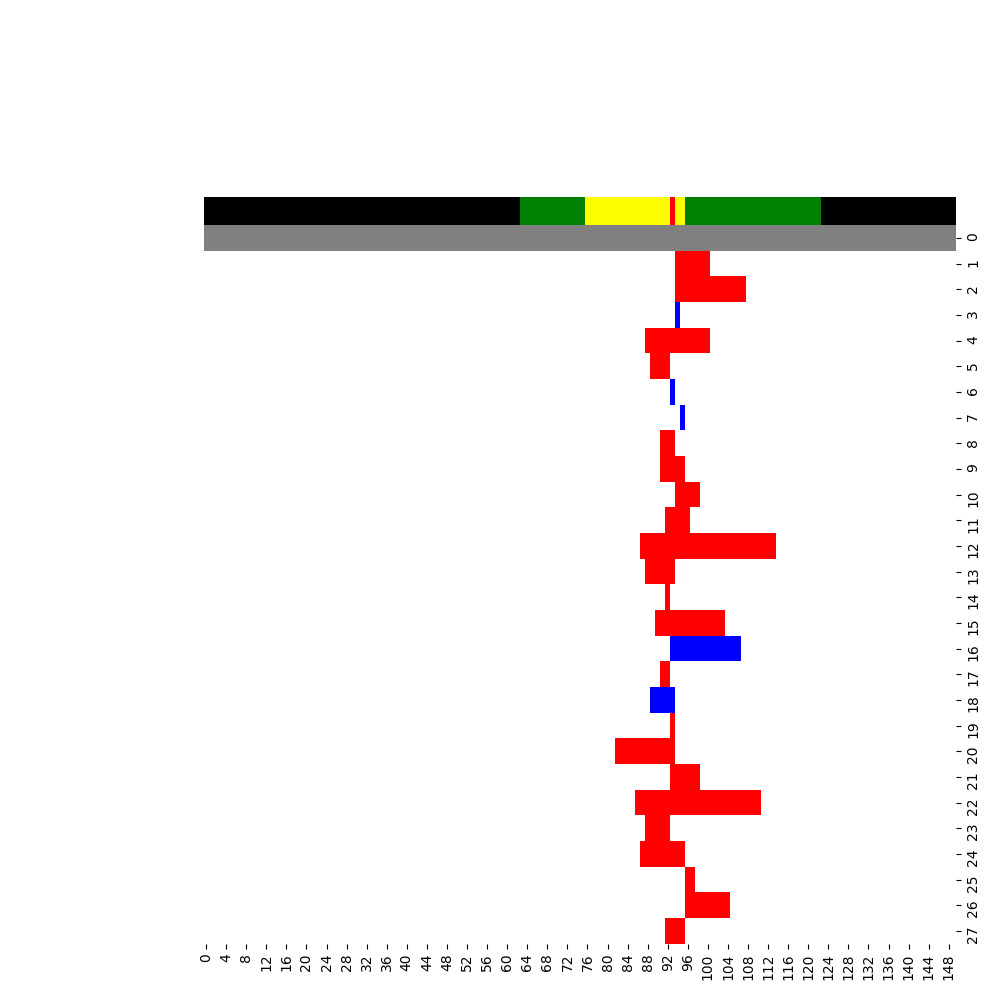

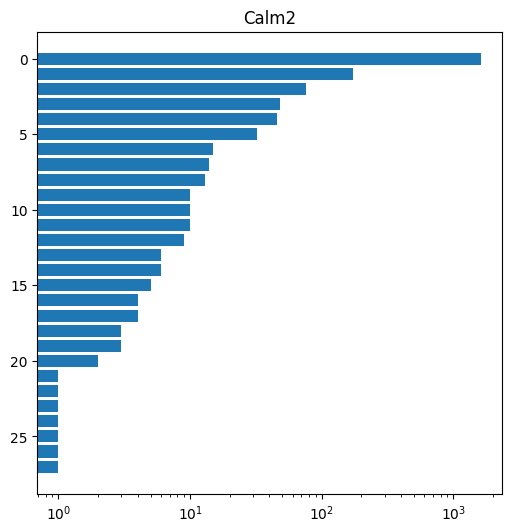

/tmp/ipykernel_216558/1184422426.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_edit_info['num'] = 1


<Figure size 600x600 with 0 Axes>

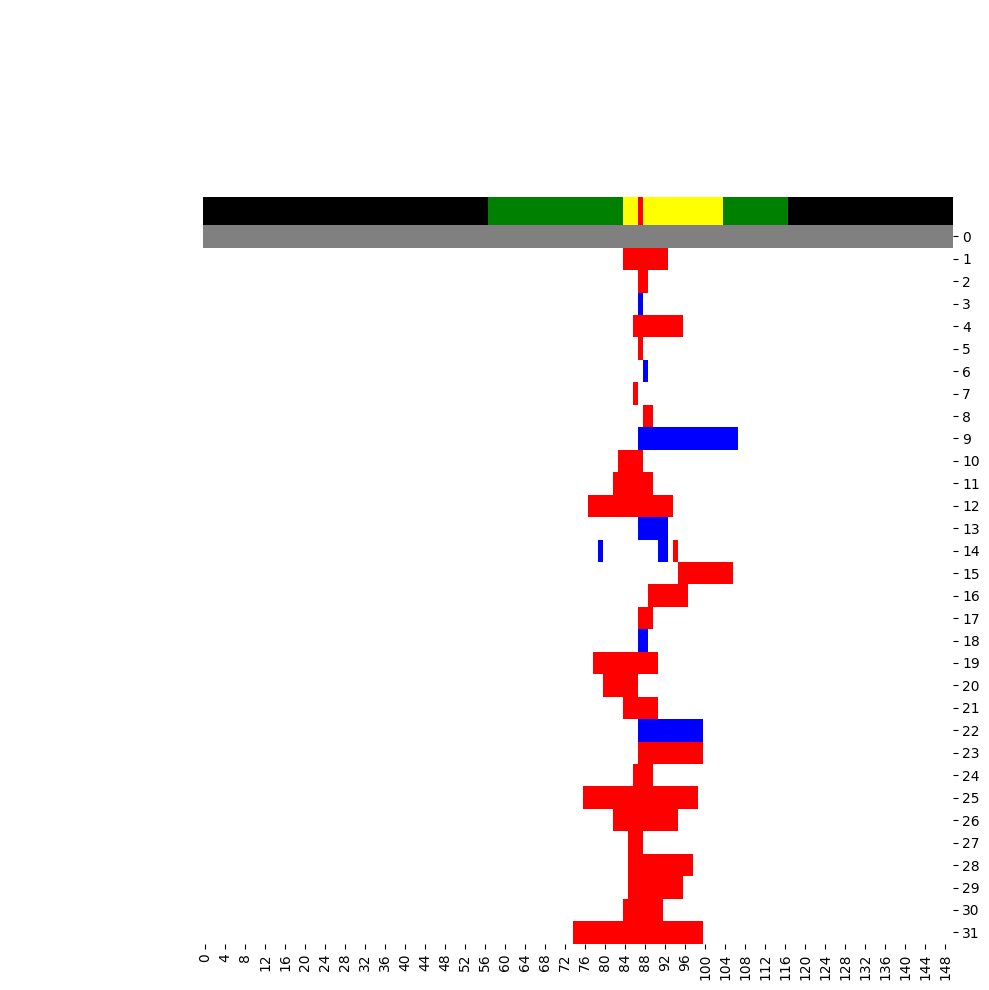

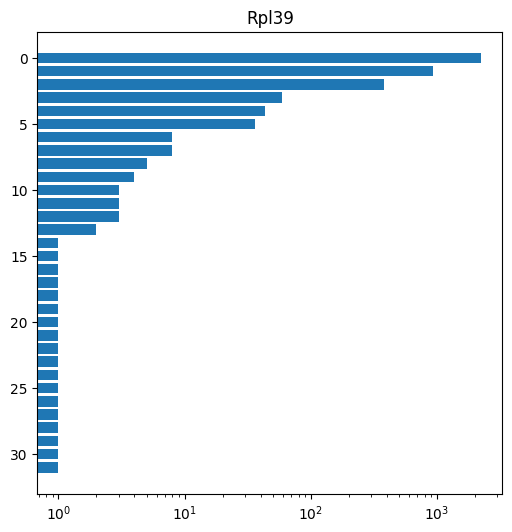

/tmp/ipykernel_216558/1184422426.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_edit_info['num'] = 1


<Figure size 600x600 with 0 Axes>

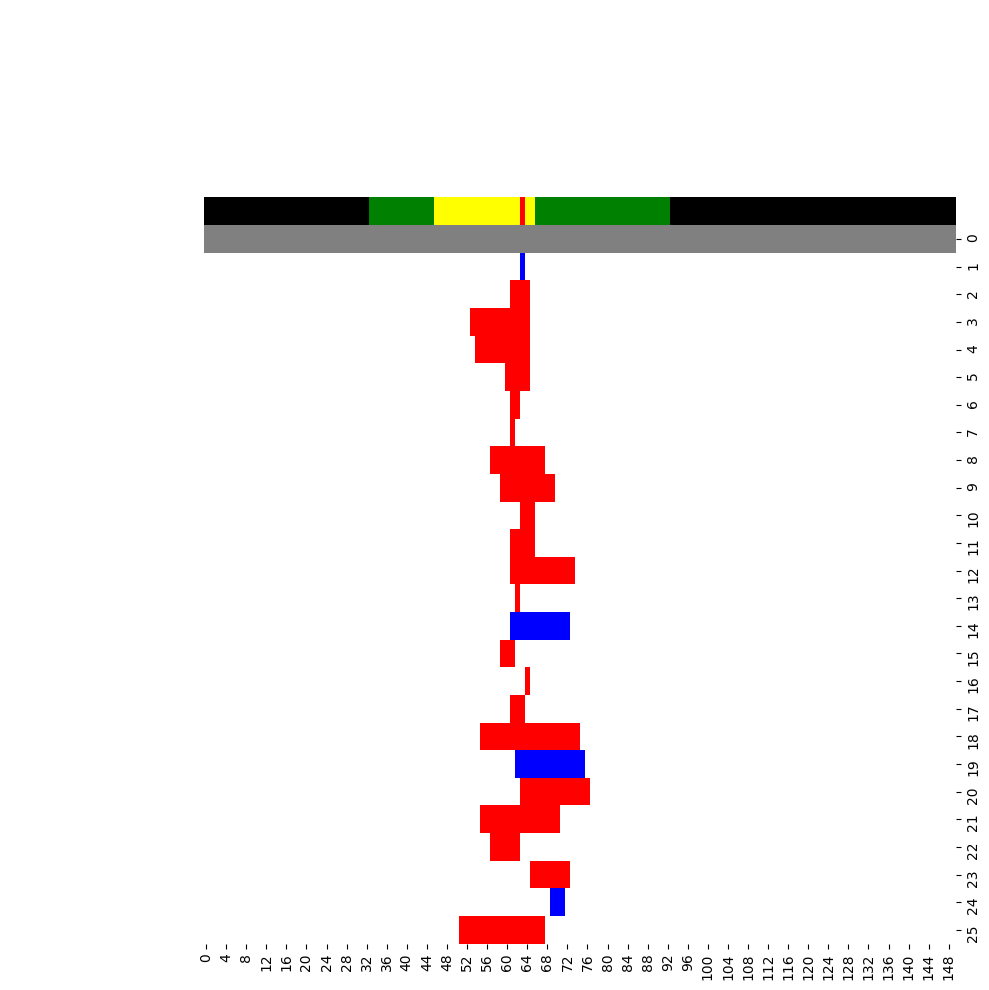

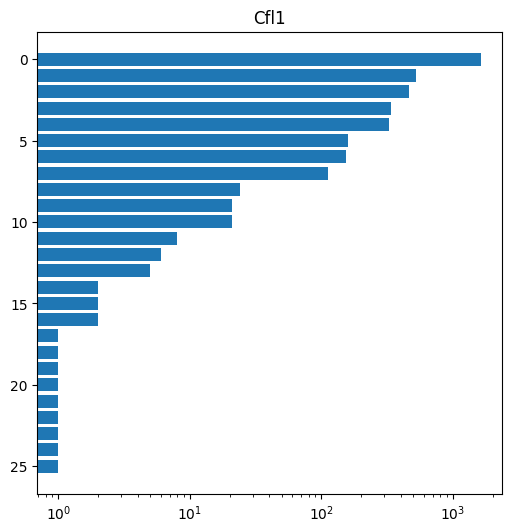

/tmp/ipykernel_216558/1184422426.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_edit_info['num'] = 1


<Figure size 600x600 with 0 Axes>

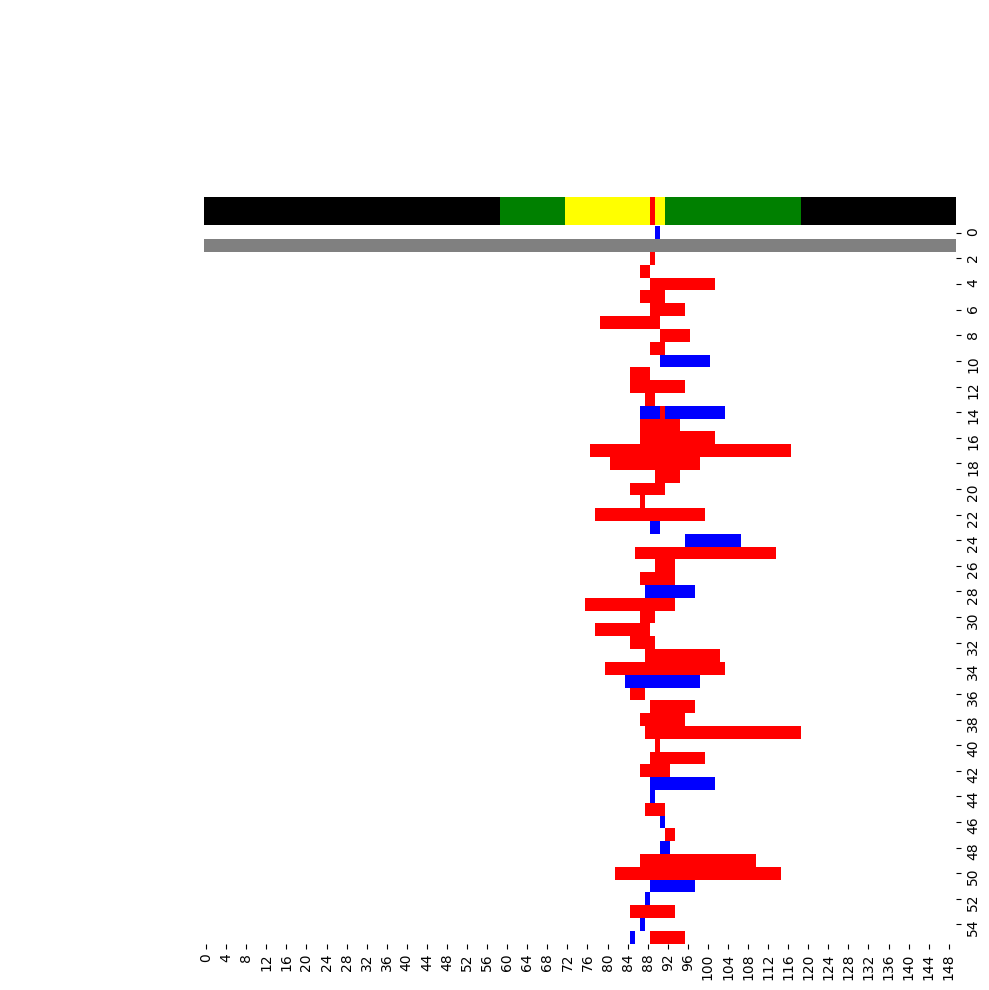

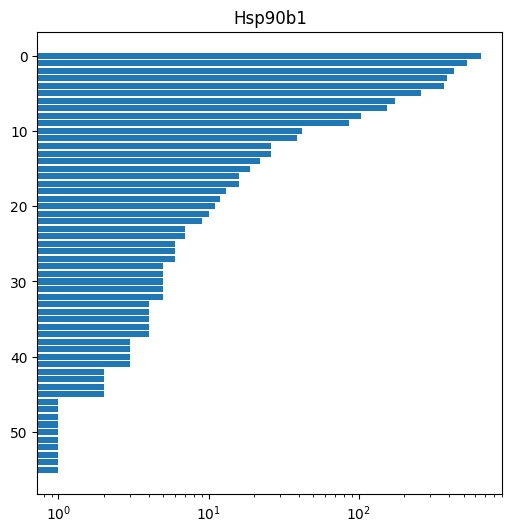

/tmp/ipykernel_216558/1184422426.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_edit_info['num'] = 1


<Figure size 600x600 with 0 Axes>

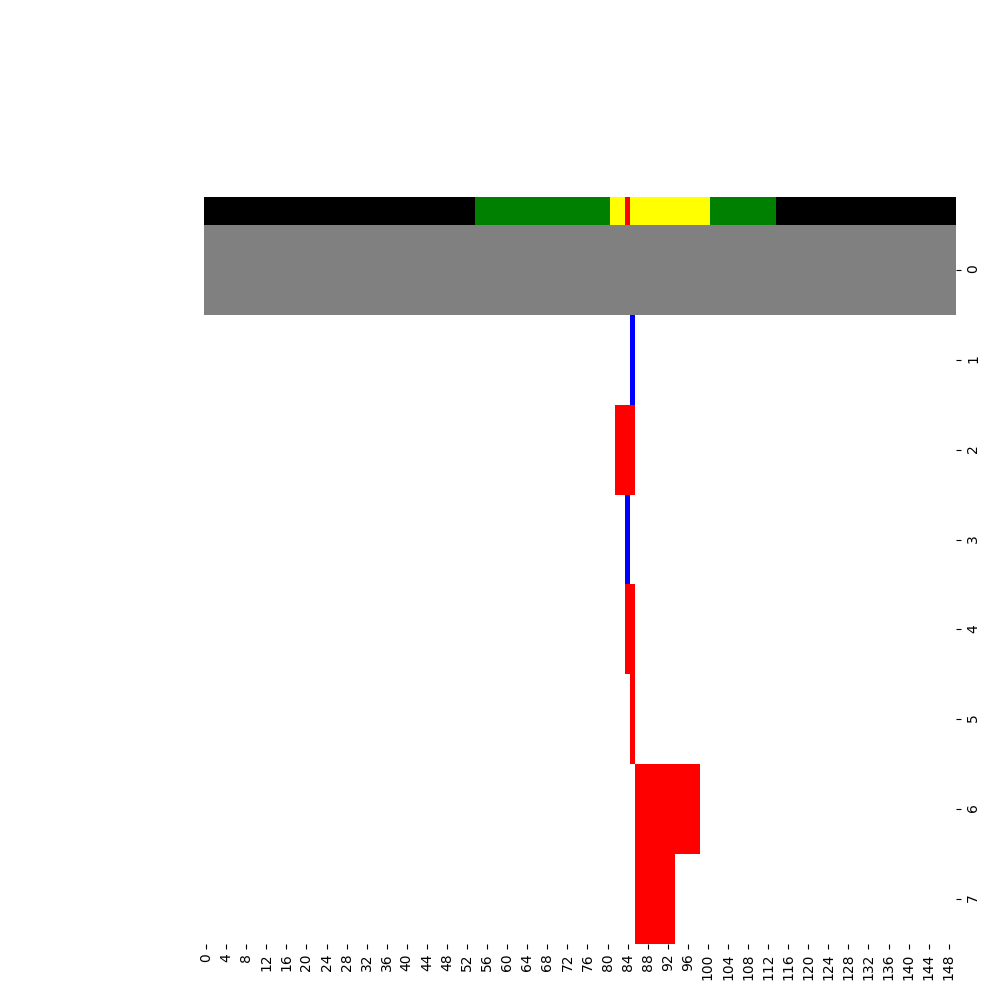

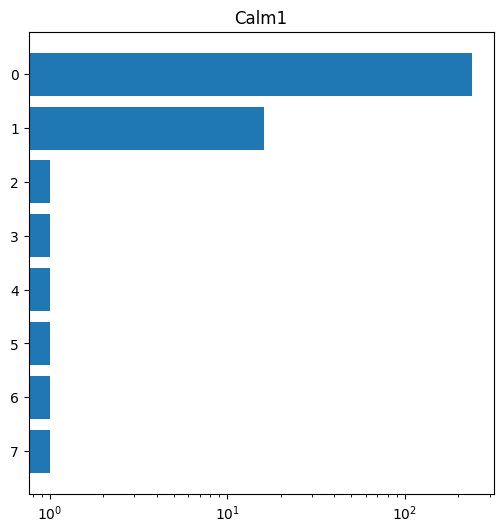

/tmp/ipykernel_216558/1184422426.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_edit_info['num'] = 1


<Figure size 600x600 with 0 Axes>

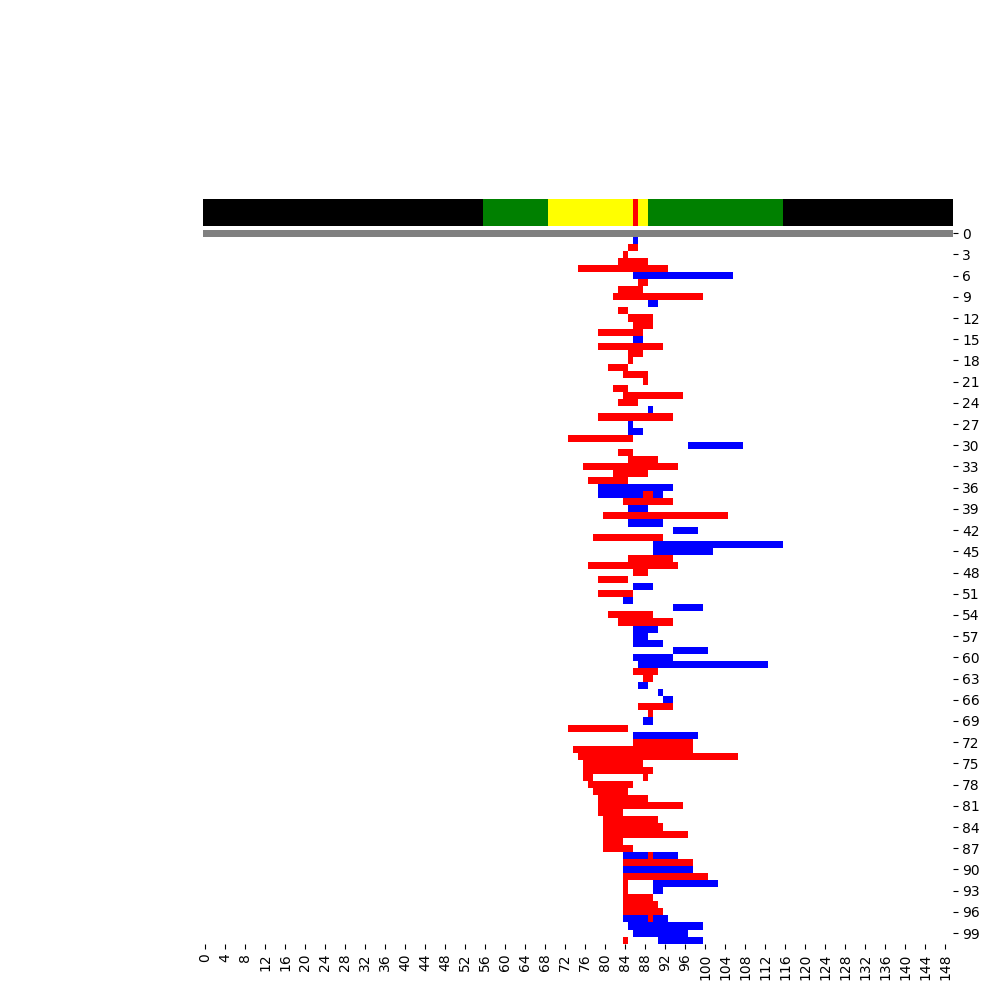

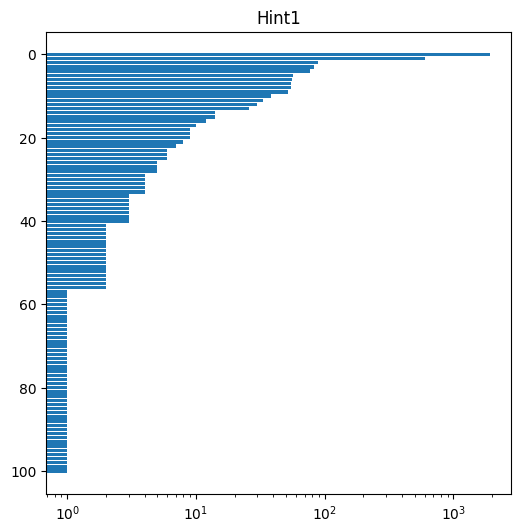

/tmp/ipykernel_216558/1184422426.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_edit_info['num'] = 1


<Figure size 600x600 with 0 Axes>

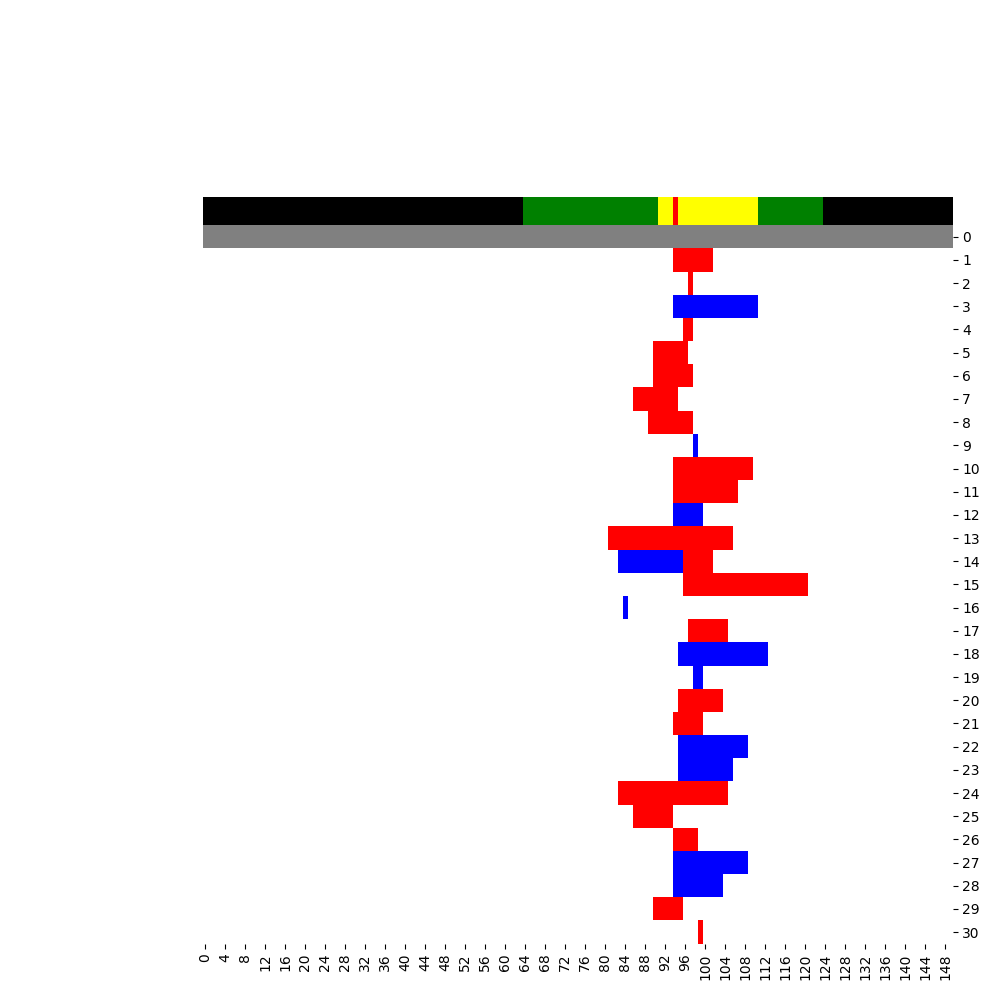

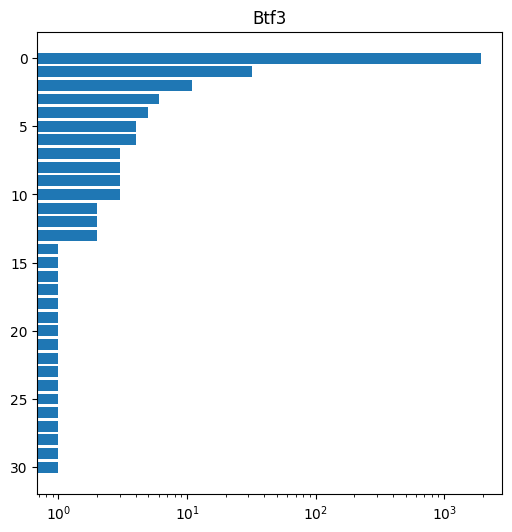

/tmp/ipykernel_216558/1184422426.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_edit_info['num'] = 1


<Figure size 600x600 with 0 Axes>

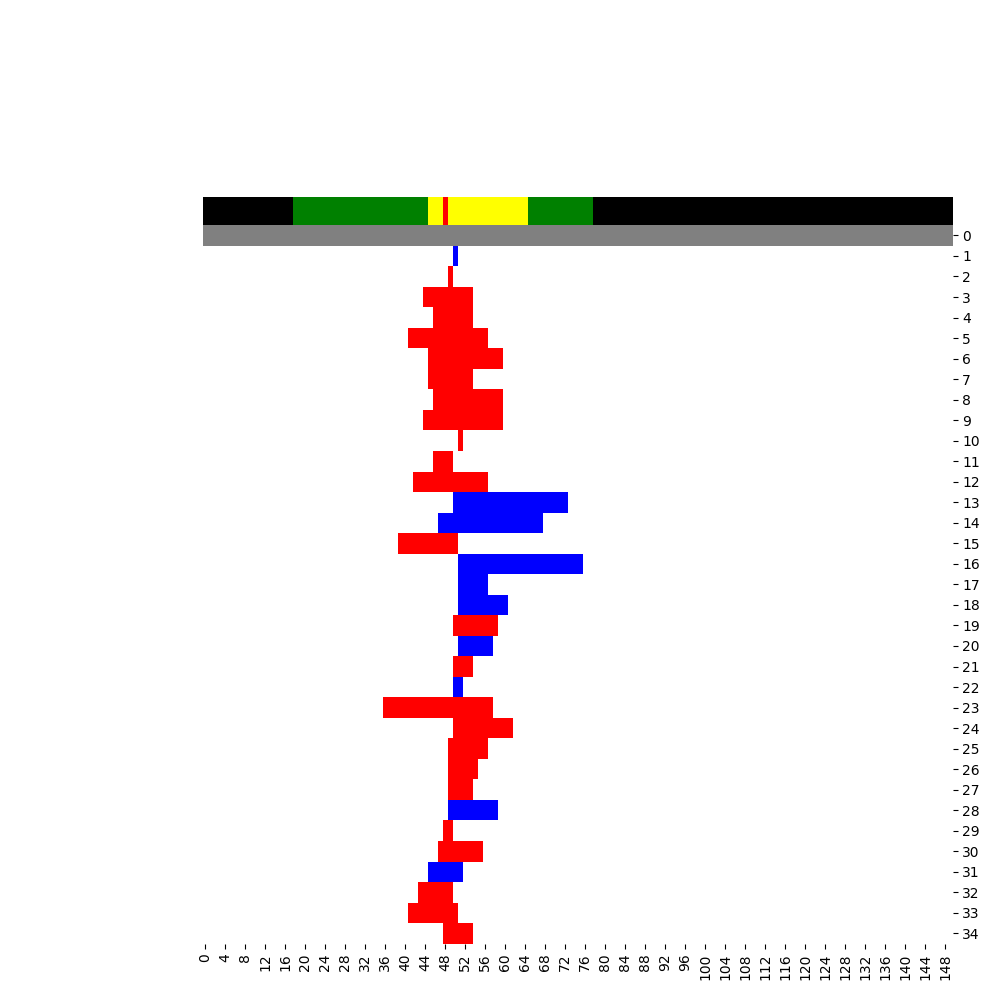

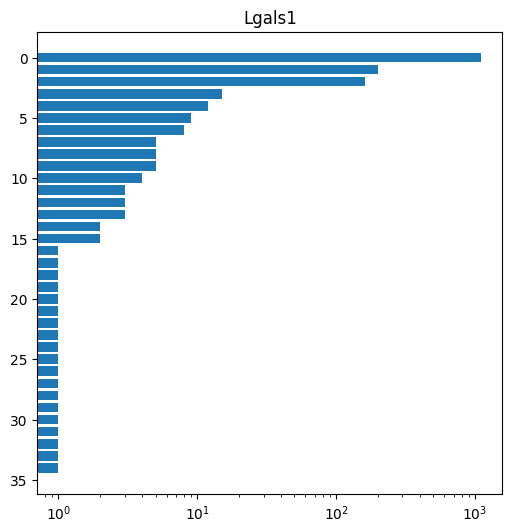

/tmp/ipykernel_216558/1184422426.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_edit_info['num'] = 1


<Figure size 600x600 with 0 Axes>

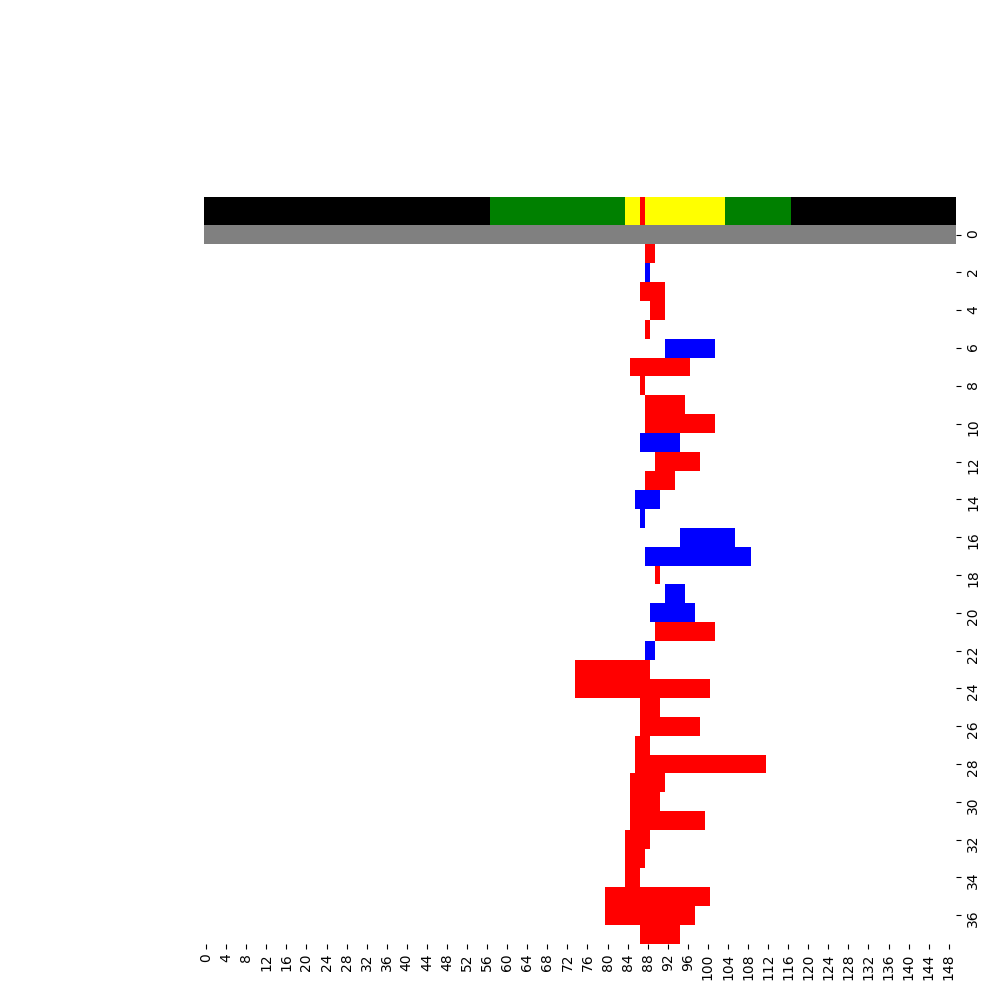

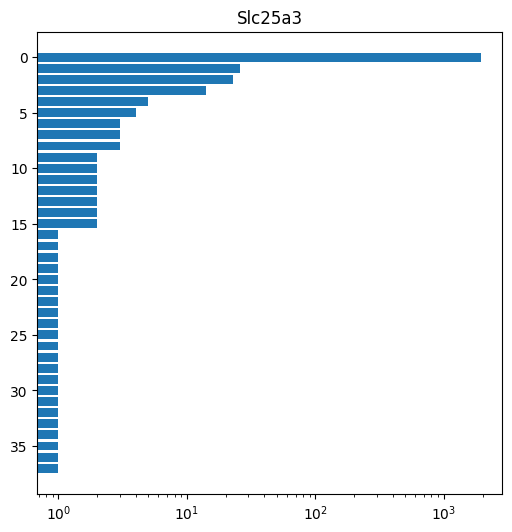

/tmp/ipykernel_216558/1184422426.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_edit_info['num'] = 1


<Figure size 600x600 with 0 Axes>

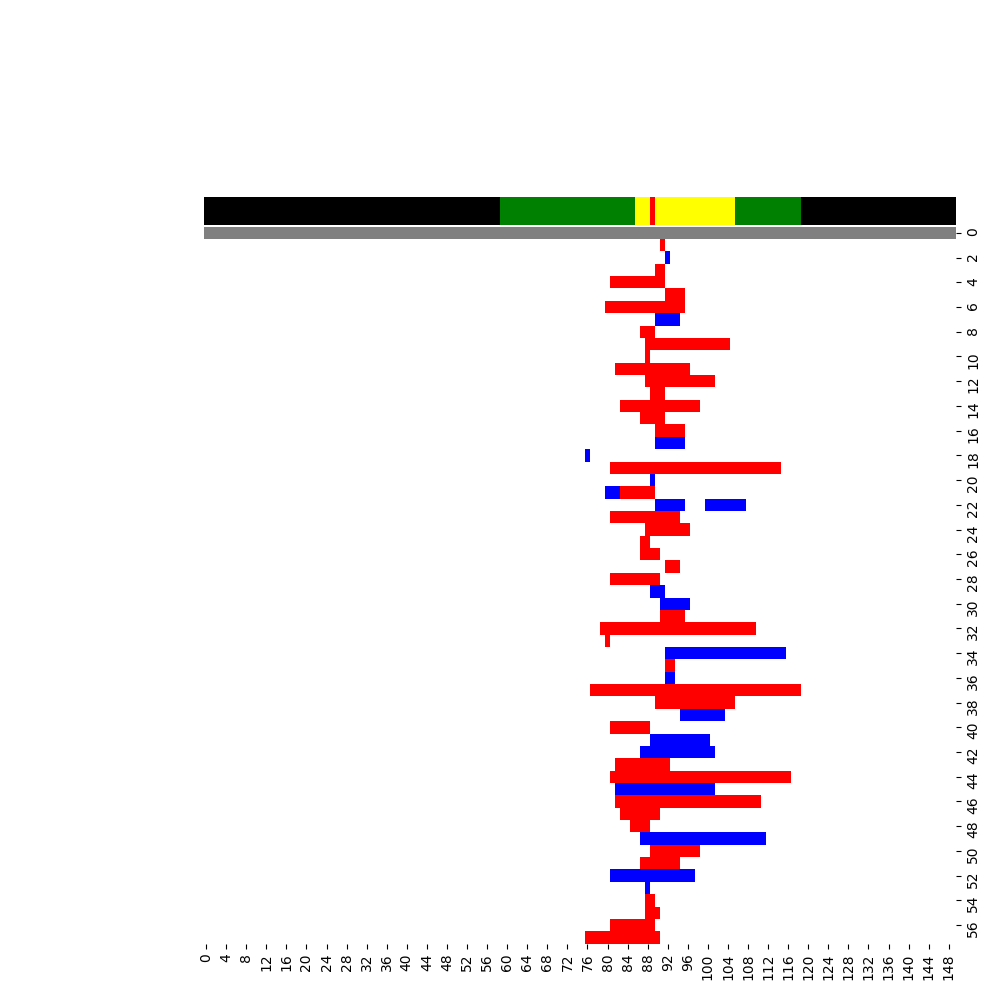

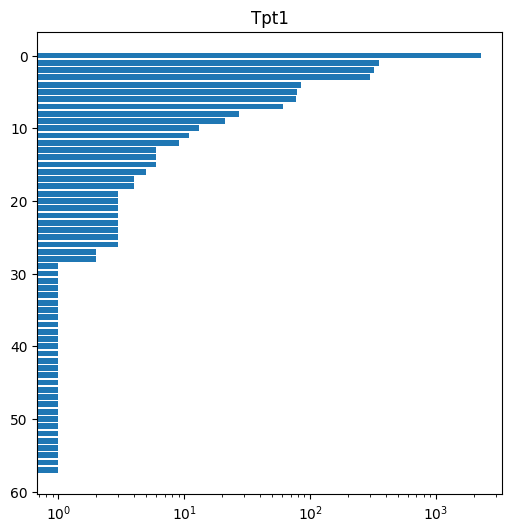

/tmp/ipykernel_216558/1184422426.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_edit_info['num'] = 1


<Figure size 600x600 with 0 Axes>

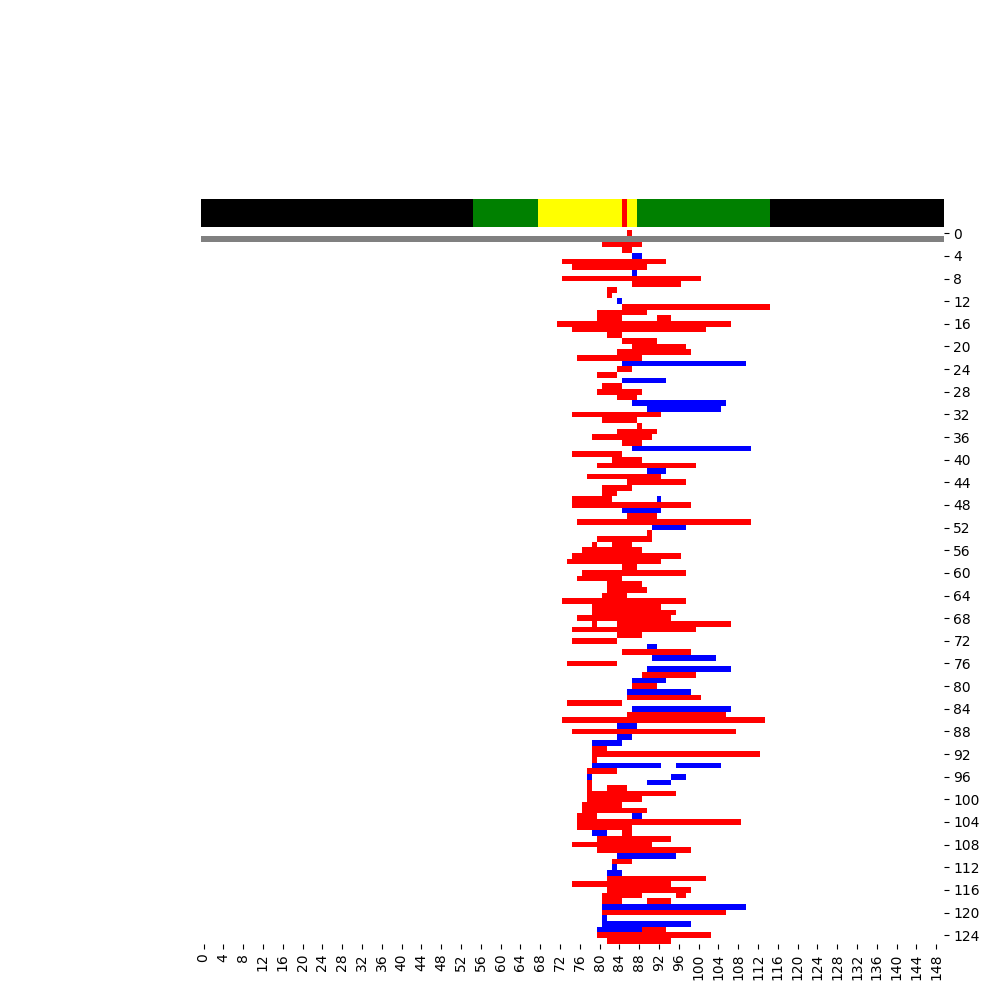

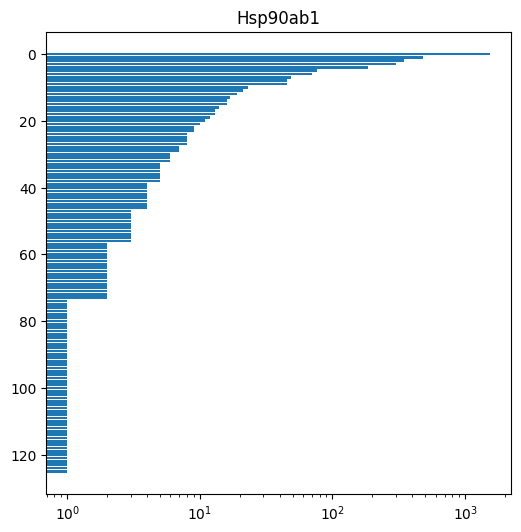

/tmp/ipykernel_216558/1184422426.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_edit_info['num'] = 1


<Figure size 600x600 with 0 Axes>

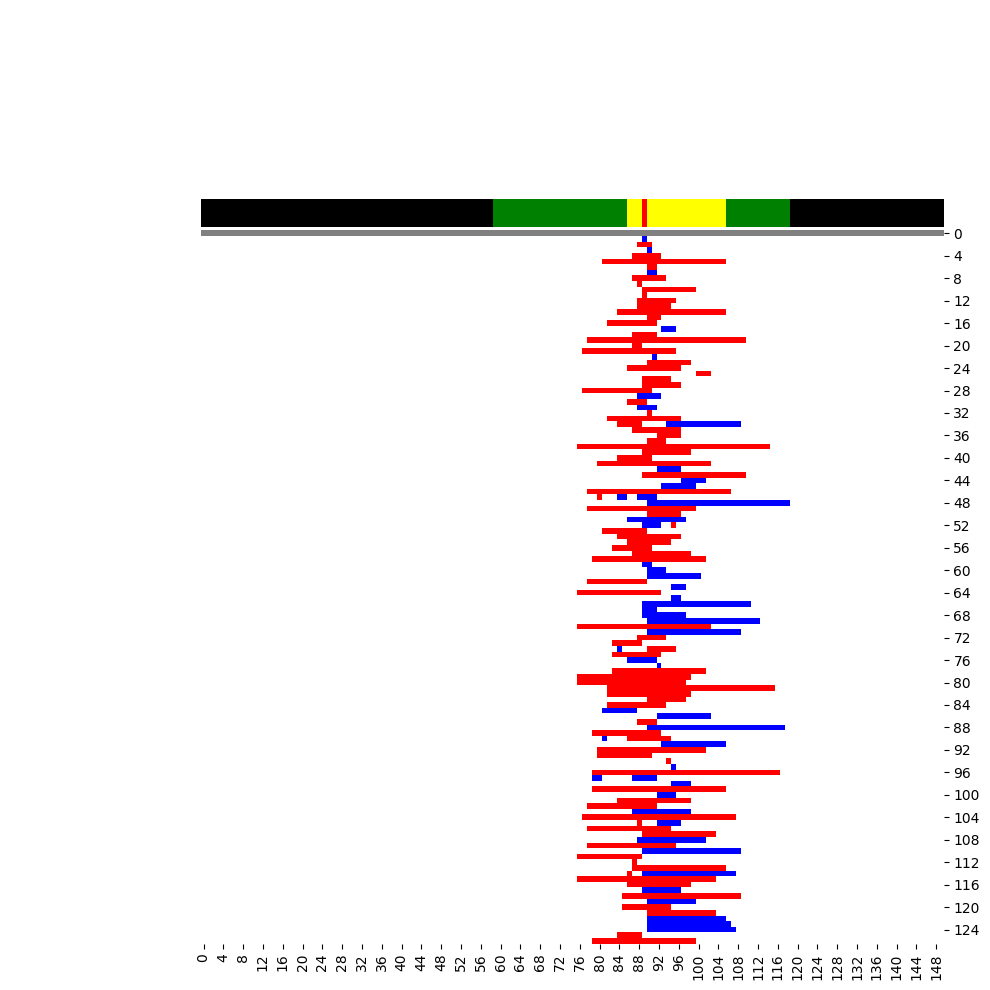

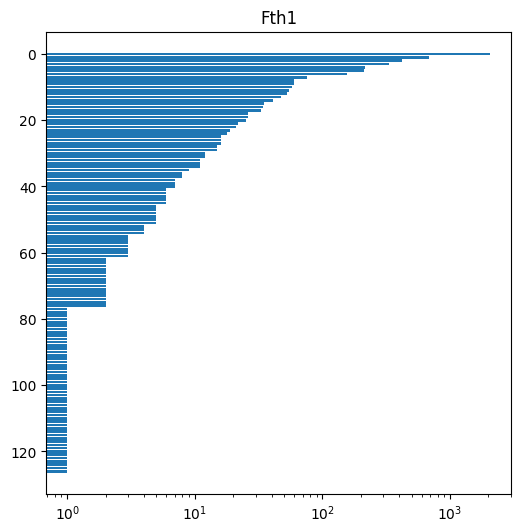

In [65]:
def edit_matrix_make(gene_edit_info):
    gene_edit_info.index = range(0,gene_edit_info.shape[0])
    edit_matrix = np.zeros([gene_edit_info.shape[0],150])

    for i in range(0,gene_edit_info.shape[0]):
        allele = gene_edit_info['r1'][i]
        
        if allele == 'None':
            edit_matrix[i,:] = 2
            continue
        
        indels = re.findall(r'(\d+)([MIDNSHP=X])', allele)
        positions = re.findall(r'(\d+)(:)', allele)
        for indel, pos in zip(indels,positions):
            #print(pos)
            count = int(indel[0])
            pos = int(pos[0])
            if indel[1] == 'I':    
                if pos-1+count < 150:
                    edit_matrix[i,pos-1:pos-1+count] = 1
            if indel[1] == 'D':
                if pos-1+count < 150:
                    edit_matrix[i,pos-1:pos-1+count] = -1

#如果编辑区在cut site 左右5bp内 remove this indel
    return edit_matrix

edit_num = []

edit_info = allele_table
gene_names=['Calr', 'Myl6', 'Calm2', 'Rpl39', 'Cfl1', 'Acta1', 'Hsp90b1', 'Calm1', 
            'Hint1', 'Btf3', 'Lgals1', 'Slc25a3', 'Tpt1', 'Hsp90ab1', 'Fth1']
cut_sites = [80,91,93,87,63,89,89,84,86,94,48,87,89,85,89]
wc = [-17,-3,-3,-17,-3,-17,-3,-17,-3,-17,-17,-17,-17,-3,-17]

counter = 0
for intBC in gene_names:
    if intBC == 'Acta1' :
        counter += 1
        continue
#for intBC in ['Hsp90ab1']:   
    gene_edit_info = edit_info[edit_info['intBC']==intBC]
    gene_edit_info['num'] = 1
    gene_edit_info = gene_edit_info.groupby(['r1'])['num'].sum().reset_index().sort_values(by='num',ascending=False)
    gene_edit_indel_info = gene_edit_info.groupby(['r1'])['num'].sum().reset_index().sort_values(by='num',ascending=False)
    edit_num.append((intBC,gene_edit_indel_info.shape[0]-1))
    
    edit_matrix = edit_matrix_make(gene_edit_info)

    colors = {0:'white', 1: 'blue', -1:'red',2:'gray'}
    color_array = [colors[i] for i in range(min(colors.keys()), max(colors.keys()) + 1)]
    cmap = ListedColormap(color_array)
    plt.figure(figsize=(6, 6))
    data_colors = []
    if wc[counter] == -17:
        sgRNA_binding_region = range(cut_sites[counter]-3,cut_sites[counter]+17)
    else:
        sgRNA_binding_region = range(cut_sites[counter]-17,cut_sites[counter]+3)
    
    cut_site_region = range(cut_sites[counter]-30,cut_sites[counter]+30)
    for i in range(0,150):
        if i == cut_sites[counter]:
            data_colors.append('red')
        elif i in sgRNA_binding_region:
            data_colors.append('yellow')
        elif i in cut_site_region:
            data_colors.append('green')
        else:
            data_colors.append('black')
    ax = sns.clustermap(edit_matrix, cmap=cmap,row_cluster=False,col_cluster=False,col_colors=data_colors)
    ax.cax.set_visible(False)
    plt.title(intBC)
    plt.show()
    
    plt.figure(figsize=(6, 6))
    plt.barh(gene_edit_info.index, gene_edit_info['num'])
    plt.xscale('log')
    plt.gca().invert_yaxis()
    plt.title(intBC)
    plt.show()
    
    counter += 1

Text(0.5, 0, '')

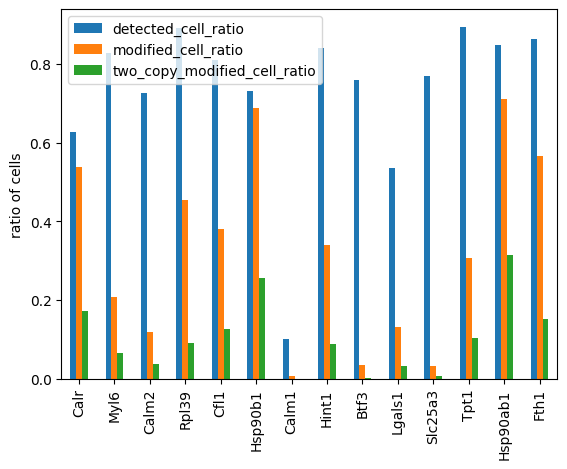

In [66]:
from collections import Counter
def call_cell_edit_ratio(edit_info,cell_num):
    cell_edited_ratio = []
    for intBC in set(edit_info['intBC']):  
        gene_edit_info = edit_info[edit_info['intBC']==intBC]
        gene_edit_info.index = range(0,gene_edit_info.shape[0])
        detected_cell = []
        modified_cell = []
        for i in range(0,gene_edit_info.shape[0]):
            if gene_edit_info.iloc[i,3] != 'None':
                modified_cell.append(gene_edit_info.iloc[i,0])
            detected_cell.append(gene_edit_info.iloc[i,0])
        two_copy_modified_cell_num = len([value for value in Counter(modified_cell).values() if value==2])
        cell_edited_ratio.append((intBC,len(set(detected_cell))/cell_num,len(set(modified_cell))/cell_num,two_copy_modified_cell_num/cell_num))
        
    return cell_edited_ratio


edit_info = allele_table
cell_num = metadata.shape[0]
cell_edited_ratio = call_cell_edit_ratio(edit_info,cell_num)


df = pd.DataFrame(cell_edited_ratio,columns=['intBC','detected_cell_ratio','modified_cell_ratio','two_copy_modified_cell_ratio'])
df.index = df.intBC
df = df.loc[['Calr', 'Myl6', 'Calm2', 'Rpl39', 'Cfl1', 'Hsp90b1', 'Calm1', 
            'Hint1', 'Btf3', 'Lgals1', 'Slc25a3', 'Tpt1', 'Hsp90ab1', 'Fth1'],:]

df.plot(kind='bar')
plt.ylabel('ratio of cells')
plt.xlabel('')


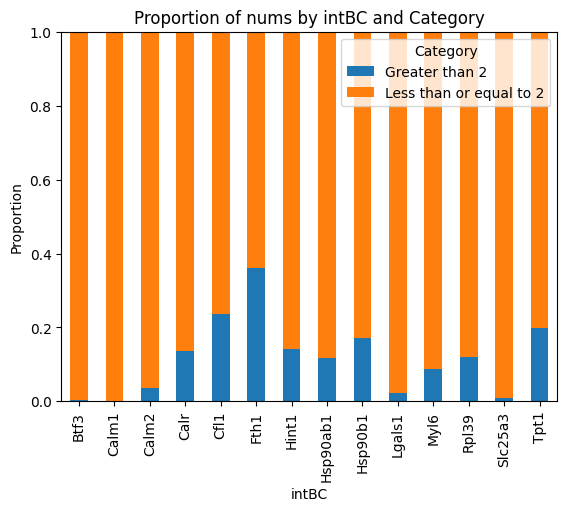

In [67]:
allele_table['num'] = 1
stat_copy = allele_table.groupby(['cellBC','intBC'])['num'].sum().reset_index()

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 创建示例数据框
data = stat_copy

# 计算每个组中满足条件的数值比例
def calculate_proportion(df, condition):
    return df[condition].groupby(df['intBC']).size() / df.groupby('intBC').size()

# 条件：数值大于2
condition_greater = data['num'] > 2
proportion_greater = calculate_proportion(data, condition_greater).reset_index(name='proportion')
proportion_greater['category'] = 'Greater than 2'

# 条件：数值小于等于2
condition_less_equal = data['num'] <= 2
proportion_less_equal = calculate_proportion(data, condition_less_equal).reset_index(name='proportion')
proportion_less_equal['category'] = 'Less than or equal to 2'

# 合并两个数据框
proportions = pd.concat([proportion_greater, proportion_less_equal])

# 绘制堆积条形图
proportions_pivot = proportions.pivot(index='intBC', columns='category', values='proportion').fillna(0)
proportions_pivot.plot(kind='bar', stacked=True)

plt.xlabel('intBC')
plt.ylabel('Proportion')
plt.title('Proportion of nums by intBC and Category')

plt.ylim(0, 1)  # 确保 y 轴比例范围在 0 到 1 之间

plt.legend(title='Category')
plt.show()


In [68]:
allele_table = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/trees/multiome_allele_table.csv',header=0,index_col=0,na_filter=False)

<Axes: ylabel='mut_num'>

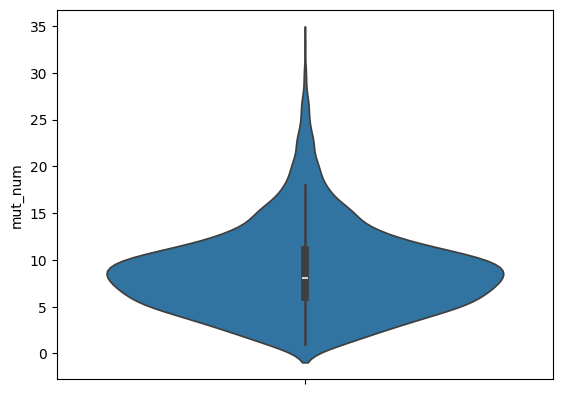

In [69]:
allele_table = allele_table[allele_table['r1']!='None']
allele_table['mut_num'] = 1
mutation_num = allele_table.groupby(['cellBC'])['mut_num'].sum().reset_index()
sns.violinplot(mutation_num,y="mut_num")

In [70]:
allele_table

,cellBC,intBC,r1,allele,readCount,UMI,UMI_ratio,lineageGrp,mut_num
3,TTATGCGCATCGCTCC,Rpl39,85:9D,85:9D,1487,30,0.405405,3,1
4,TTATGCGCATCGCTCC,Rpl39,88:2D,88:2D,1374,30,0.405405,3,1
9,TTATGCGCATCGCTCC,Myl6,90:2D,90:2D,2744,23,0.294872,3,1
10,TTATGCGCATCGCTCC,Fth1,90:1I,90:1I,1460,22,0.282051,3,1
11,TTATGCGCATCGCTCC,Fth1,88:2D,88:2D,1091,17,0.217949,3,1
...,...,...,...,...,...,...,...,...,...
40423,CCATTATTCGGTCATG,Hsp90b1,91:1I,91:1I,1476,3,0.250000,1,1
40424,CCATTATTCGGTCATG,Rpl39,85:9D,85:9D,103,2,0.285714,1,1
40425,CCATTATTCGGTCATG,Fth1,89:3D,89:3D,52,2,0.181818,1,1
40427,CCTGGTAAGGCTAATC,Rpl39,85:9D,85:9D,74,2,0.666667,3,1


In [71]:
metadata = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/scATAC_and_scRNA/multiome_RNA_metadata.csv',header=0,sep=',',index_col=0)
metadata.index = [ cellBC.strip('-1') for cellBC in metadata.index]
metadata

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.8,seurat_clusters,RNA_snn_res.0.3,RNA_snn_res.0.4,RNA_snn_res.0.6,predicted.id,prediction.score.2,prediction.score.1,prediction.score.3,prediction.score.4,prediction.score.5,prediction.score.max,umap_1,umap_2
AAACAGCCAGGCCATT,SeuratProject,59544,7436,13.786444,4,1,1,0,4,2,1.000000,0.000000,0.000000,0.0,0.000000,1.000000,-5.939390,0.619506
AAACATGCACCCTCAC,SeuratProject,11604,3725,10.617029,3,0,0,3,2,3,0.000000,0.236366,0.763634,0.0,0.000000,0.763634,3.650231,-0.803575
AAACATGCAGGCTACT,SeuratProject,17107,4309,17.793886,3,0,0,3,2,3,0.004506,0.130255,0.584066,0.0,0.281173,0.584066,1.319984,-0.223603
AAACCGCGTCTTGCTG,SeuratProject,17680,4029,19.049774,1,0,0,2,1,3,0.000000,0.010647,0.989353,0.0,0.000000,0.989353,3.240033,-0.833046
AAACCGCGTGGTTCTT,SeuratProject,9952,2878,18.488746,2,1,1,0,3,2,1.000000,0.000000,0.000000,0.0,0.000000,1.000000,-3.179854,2.550274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCTAGTCTCACC,SeuratProject,21752,4947,11.511585,2,1,1,0,3,2,1.000000,0.000000,0.000000,0.0,0.000000,1.000000,-3.198943,1.809564
TTTGTGAAGTTTGCGG,SeuratProject,13142,3660,8.088571,0,0,0,2,1,3,0.000000,0.000000,1.000000,0.0,0.000000,1.000000,1.524957,0.414417
TTTGTGGCAGCACCAT,SeuratProject,9245,2845,14.753921,1,2,2,1,0,3,0.000000,0.066865,0.933135,0.0,0.000000,0.933135,1.001207,-1.298838
TTTGTGTTCATAATCG,SeuratProject,11275,3176,12.292683,0,0,0,2,1,3,0.000000,0.000000,1.000000,0.0,0.000000,1.000000,3.662393,1.413214


In [72]:
allele_table['cluster'] = metadata.loc[allele_table.cellBC,'predicted.id'].to_list()

In [73]:
allele_table

,cellBC,intBC,r1,allele,readCount,UMI,UMI_ratio,lineageGrp,mut_num,cluster
3,TTATGCGCATCGCTCC,Rpl39,85:9D,85:9D,1487,30,0.405405,3,1,2
4,TTATGCGCATCGCTCC,Rpl39,88:2D,88:2D,1374,30,0.405405,3,1,2
9,TTATGCGCATCGCTCC,Myl6,90:2D,90:2D,2744,23,0.294872,3,1,2
10,TTATGCGCATCGCTCC,Fth1,90:1I,90:1I,1460,22,0.282051,3,1,2
11,TTATGCGCATCGCTCC,Fth1,88:2D,88:2D,1091,17,0.217949,3,1,2
...,...,...,...,...,...,...,...,...,...,...
40423,CCATTATTCGGTCATG,Hsp90b1,91:1I,91:1I,1476,3,0.250000,1,1,3
40424,CCATTATTCGGTCATG,Rpl39,85:9D,85:9D,103,2,0.285714,1,1,3
40425,CCATTATTCGGTCATG,Fth1,89:3D,89:3D,52,2,0.181818,1,1,3
40427,CCTGGTAAGGCTAATC,Rpl39,85:9D,85:9D,74,2,0.666667,3,1,3


<Axes: xlabel='cluster', ylabel='mut_num'>

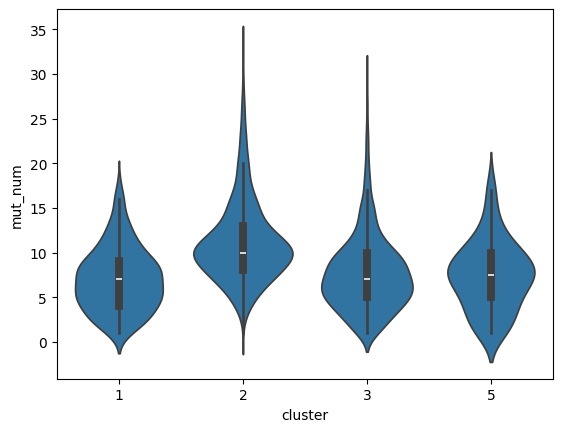

In [74]:
mutation_num = allele_table.groupby(['cellBC','cluster'])['mut_num'].sum().reset_index()
sns.violinplot(mutation_num,x='cluster',y="mut_num")

<Axes: xlabel='lineageGrp', ylabel='mut_num'>

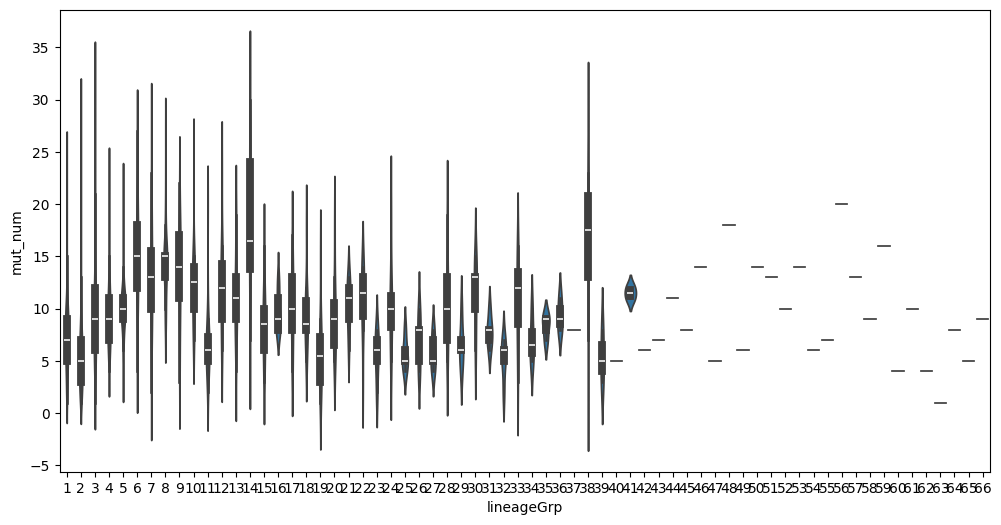

In [75]:
plt.figure(figsize=(12, 6))
mutation_num = allele_table.groupby(['cellBC','lineageGrp'])['mut_num'].sum().reset_index()
sns.violinplot(mutation_num,x='lineageGrp',y="mut_num")

# 0-1 matrix

In [1]:
import pandas as pd

In [2]:
allele_table = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/trees/multiome_allele_table.csv',header=0,index_col=0,na_filter=False)

In [3]:
allele_table = allele_table[allele_table['r1'] != 'None']
allele_table

,cellBC,intBC,r1,allele,readCount,UMI,UMI_ratio,lineageGrp
3,TTATGCGCATCGCTCC,Rpl39,85:9D,85:9D,1487,30,0.405405,3
4,TTATGCGCATCGCTCC,Rpl39,88:2D,88:2D,1374,30,0.405405,3
9,TTATGCGCATCGCTCC,Myl6,90:2D,90:2D,2744,23,0.294872,3
10,TTATGCGCATCGCTCC,Fth1,90:1I,90:1I,1460,22,0.282051,3
11,TTATGCGCATCGCTCC,Fth1,88:2D,88:2D,1091,17,0.217949,3
...,...,...,...,...,...,...,...,...
40423,CCATTATTCGGTCATG,Hsp90b1,91:1I,91:1I,1476,3,0.250000,1
40424,CCATTATTCGGTCATG,Rpl39,85:9D,85:9D,103,2,0.285714,1
40425,CCATTATTCGGTCATG,Fth1,89:3D,89:3D,52,2,0.181818,1
40427,CCTGGTAAGGCTAATC,Rpl39,85:9D,85:9D,74,2,0.666667,3


In [4]:
cell_lineage = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/multiome/cell_lineage.csv')

In [5]:
cell_lineage['lineageGrp'].value_counts() > 100

lineageGrp
3      True
1      True
2      True
5      True
4      True
      ...  
49    False
44    False
53    False
66    False
57    False
Name: count, Length: 66, dtype: bool

In [6]:
gene_names = set(allele_table['intBC'])

cell_mutation_matrix = pd.DataFrame(index=list(set(allele_table['cellBC'])))
for gene in gene_names:
    print(gene)
    allele_table_gene = allele_table[allele_table['intBC']==gene]
    if allele_table_gene.shape[0] == 0:
        continue
    df = allele_table_gene.pivot(index='cellBC', columns='r1', values='UMI')
    df= df.fillna(0)
    df[df > 0] = 1
    df.columns = [gene + '_' + indel for indel in df.columns]
    cell_mutation_matrix = cell_mutation_matrix.join(df, how='outer')
    cell_mutation_matrix = cell_mutation_matrix.fillna(0)

cell_mutation_matrix = cell_mutation_matrix.loc[:, (cell_mutation_matrix != 0).any(axis=0)]

cell_mutation_matrix.loc['synthetic'] = [ 0 for i in range(0,cell_mutation_matrix.shape[1])]
cell_mutation_matrix = cell_mutation_matrix.astype(int)


for lineageGrp in cell_lineage['lineageGrp'].unique():

    cell_mutation_matrix_lineageGrp = cell_mutation_matrix.loc[cell_mutation_matrix.index.isin(cell_lineage[cell_lineage['lineageGrp'].isin([lineageGrp])]['cellBC']),:]           
    cell_mutation_matrix_lineageGrp = cell_mutation_matrix_lineageGrp.astype(int)
    if cell_mutation_matrix_lineageGrp.shape[0] < 50:
        continue

    cell_mutation_matrix_lineageGrp = cell_mutation_matrix_lineageGrp.loc[:, (cell_mutation_matrix_lineageGrp != 0).any(axis=0)]
    if cell_mutation_matrix_lineageGrp.shape[1] == 0:
        continue
    cell_mutation_matrix_lineageGrp.loc['synthetic'] = [ 0 for i in range(0,cell_mutation_matrix_lineageGrp.shape[1])]

    cell_mutation_matrix_lineageGrp.to_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/trees/multiome/polytomy/'+'cell_mutation_matrix-C'+str(lineageGrp)+'-'+str(cell_mutation_matrix_lineageGrp.shape[0])+'.csv')

    cell_mutation_sequence = cell_mutation_matrix_lineageGrp.apply(lambda row: ''.join(row.astype(str)), axis=1)
    output_file = '/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/trees/multiome/polytomy/'+ 'cell_mutation_matrix-C'+str(lineageGrp)+'-'+str(cell_mutation_matrix_lineageGrp.shape[0])+'.phy'
    with open(output_file, 'w') as file:
        file.write(f"{cell_mutation_matrix_lineageGrp.shape[0]} \t{cell_mutation_matrix_lineageGrp.shape[1]}\n") 
        for index, line in cell_mutation_sequence.items():
            file.write(f"{index}\t{line}\n")  



Hsp90b1
Lgals1
Btf3
Rpl39
Calr
Hsp90ab1
Hint1
Fth1
Tpt1
Calm1
Myl6
Calm2
Cfl1
Slc25a3


## merge clone mutation

In [9]:
import pandas as pd

In [23]:
allele_table = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/trees/multiome_allele_table.csv',header=0,index_col=0,na_filter=False)

In [24]:
allele_table

,cellBC,intBC,r1,allele,readCount,UMI,UMI_ratio,lineageGrp
0,TTATGCGCATCGCTCC,Tpt1,None,None,11551,325,0.984848,3
1,TTATGCGCATCGCTCC,Myl6,None,None,7716,53,0.679487,3
2,TTATGCGCATCGCTCC,Cfl1,None,None,3666,40,0.689655,3
3,TTATGCGCATCGCTCC,Rpl39,85:9D,85:9D,1487,30,0.405405,3
4,TTATGCGCATCGCTCC,Rpl39,88:2D,88:2D,1374,30,0.405405,3
...,...,...,...,...,...,...,...,...
40429,ATCATGTCATGCATAT,Fth1,None,None,134,4,0.571429,3
40430,ATCATGTCATGCATAT,Rpl39,None,None,152,3,0.750000,3
40431,ATCATGTCATGCATAT,Tpt1,82:11D,82:11D,143,2,0.222222,3
40432,AGAGGAACAAGCTTAT,Tpt1,None,None,259,6,0.857143,1


In [25]:
cell_lineage = pd.read_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/multiome/cell_lineage.csv')

In [26]:
lineageGrp_selected = cell_lineage['lineageGrp'].value_counts().index[(cell_lineage['lineageGrp'].value_counts() >= 50)]
lineageGrp_selected

Index([3, 1, 2, 5, 4, 6, 7, 8], dtype='int64', name='lineageGrp')

In [27]:
cell_lineage = cell_lineage[cell_lineage['lineageGrp'].isin(lineageGrp_selected)]
cell_lineage = cell_lineage.groupby('lineageGrp', group_keys=False).apply(lambda x: x.sample(n=min(50, len(x)), random_state=42))
cell_lineage['lineageGrp'].value_counts()
cell_lineage

,cellBC,lineageGrp
883,CAGCCAATCTACCTCA,1
963,TCTAATCTCTAAGTCA,1
579,ACAGGCTGTTAACGGC,1
757,ACGACAAAGTATGTGC,1
651,CGTTAACAGCACGTTG,1
...,...,...
1899,GCCAGGAAGAGGAGTC,8
1934,ACTTTGTTCTGTGAGT,8
1906,AGTCCTTGTTTGGGCG,8
1920,GCCTTAACAACAGGTG,8


In [28]:
lineageGrp_selected

Index([3, 1, 2, 5, 4, 6, 7, 8], dtype='int64', name='lineageGrp')

In [29]:
allele_table = allele_table[allele_table['cellBC'].isin(cell_lineage['cellBC'])]

In [30]:
allele_table

,cellBC,intBC,r1,allele,readCount,UMI,UMI_ratio,lineageGrp
202,AGTTTGATCCCGCCTA,Tpt1,None,None,6603,192,0.964824,4
203,AGTTTGATCCCGCCTA,Rpl39,None,None,4449,89,0.967391,4
204,AGTTTGATCCCGCCTA,Fth1,None,None,5238,70,0.886076,4
205,AGTTTGATCCCGCCTA,Hsp90ab1,None,None,3777,33,0.515625,4
206,AGTTTGATCCCGCCTA,Cfl1,None,None,2736,27,0.931034,4
...,...,...,...,...,...,...,...,...
40409,ATGGTCTAGTAACGAG,Tpt1,None,None,38,3,0.214286,6
40410,ATGGTCTAGTAACGAG,Slc25a3,90:3D,90:3D,1088,2,1.000000,6
40411,ATGGTCTAGTAACGAG,Calm2,None,None,1082,2,0.666667,6
40412,ATGGTCTAGTAACGAG,Tpt1,89:1D,89:1D,235,2,0.142857,6


In [31]:
len(set(allele_table['cellBC']))

400

In [32]:
gene_names = ['Acta1', 'Hsp90b1','Calr','Cfl1','Myl6','Rpl39','Calm2','Fth1','Hsp90ab1','Tpt1','Slc25a3','Lgals1','Btf3','Hint1','Calm1']
allele_table = allele_table[allele_table['r1']!='None']
cell_mutation_matrix = pd.DataFrame(index=list(set(allele_table['cellBC'])))
for gene in gene_names:
    print(gene)
    allele_table_gene = allele_table[allele_table['intBC']==gene]
    df = allele_table_gene.pivot(index='cellBC', columns='r1', values='UMI')
    df= df.fillna(0)
    df[df > 0] = 1
    df.columns = [gene + '_' + indel for indel in df.columns]
    cell_mutation_matrix = cell_mutation_matrix.join(df, how='outer')
    cell_mutation_matrix = cell_mutation_matrix.fillna(0)

cell_mutation_matrix.loc['synthetic'] = [ 0 for i in range(0,cell_mutation_matrix.shape[1])]
cell_mutation_matrix = cell_mutation_matrix.astype(int)

cell_mutation_matrix.to_csv('/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/trees/multiome/'+'multiome'+'-'+str(cell_mutation_matrix.shape[0])+'.csv')

cell_mutation_sequence = cell_mutation_matrix.apply(lambda row: ''.join(row.astype(str)), axis=1)
output_file = '/syn1/liangzhen/jinhua_jilab_project/result/DNA_Amplicon/trees/multiome/'+'multiome'+'-'+str(cell_mutation_matrix.shape[0])+'.phy'
with open(output_file, 'w') as file:
    file.write(f"{cell_mutation_matrix.shape[0]} \t{cell_mutation_matrix.shape[1]}\n") 
    for index, line in cell_mutation_sequence.items():
        file.write(f"{index}\t{line}\n")  

Acta1
Hsp90b1
Calr
Cfl1
Myl6
Rpl39
Calm2
Fth1
Hsp90ab1
Tpt1
Slc25a3
Lgals1
Btf3
Hint1
Calm1
